### libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse
import matplotlib.cm as cm

from torch import nn, autograd, optim
import torch.nn.functional as F
import torch.optim as optim
import torch
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable

from IPython.display import clear_output

### general settings

In [2]:
cuda = torch.cuda.is_available()
batch_size = 128
test_batch_size = 32

seed = 123
np.random.seed(seed=seed)

### load data: MNIST

In [3]:
# load data
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])),
    batch_size=test_batch_size, shuffle=True, **kwargs)

### Network

a simple linear ANN with two hidden layers

In [4]:
class Net(nn.Module):

    def __init__(self, n_input=784, n_hid_1=30, n_hid_2=30, n_out=10, lr=0.001, binary=False):
        super().__init__()
        
        '''
        for simplying the analysis and interpretation, no bias and activation functions are used.
        '''
        
        self.n_input = n_input
        
        # layers
        self.lin1 = nn.Linear(n_input, n_hid_1, bias=False)
        self.lin2 = nn.Linear(n_hid_1, n_hid_2, bias=False)
        self.lin3 = nn.Linear(n_hid_2, n_out, bias=False)
        
        # for learning
        self.optimizer = optim.Adam(self.parameters(), lr)
        self.criterion = nn.CrossEntropyLoss()

        self.activations = []
        self.binary = binary
        self.bound = 10 # for the binary network
        self.zero = torch.Tensor([0]).cuda()
        
    def forward(self, x, record=False):
        
        if self.binary:
            x = torch.heaviside(x.view(x.size(0), self.n_input), self.zero)
            x1 = self.lin1(x).clip(-self.bound, self.bound)     
            x2 = self.lin2(x1).clip(-self.bound, self.bound)            
            x3 = self.lin3(x2).clip(-self.bound, self.bound)
            
        else:
            x = x.view(x.size(0), self.n_input)
            x1 = self.lin1(x)     
            x2 = self.lin2(x1)
            x3 = self.lin3(x2)

        if record:
            self.activations = []
            self.activations.append(x1)
            self.activations.append(x2)
            self.activations.append(x3)
            
        return x3
    
    def train(self):
        for batch_idx, (data, target) in enumerate(train_loader):

            # input batch loading
            if cuda:
                data, target = data.cuda(), target.cuda()
           
            data, target = Variable(data), Variable(target)
            self.optimizer.zero_grad()

            # forward
            output = self.forward(x=data)
            
            # backward
            loss = self.criterion(output, target)
            loss.backward()

            self.optimizer.step()

        return np.around(loss.data.item(), 3)


    def test(self):
        
        with torch.no_grad():
            test_loss = 0
            correct = 0

            for data, target in test_loader:
                if cuda:
                    data, target = data.cuda(), target.cuda()
                data, target = Variable(data), Variable(target)
                output = self.forward(data)
                
                test_loss += self.criterion(output, target).data.item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).cpu().sum()

            best_acc = 100. * float(correct) / len(test_loader.dataset)
        
        test_loss /= len(test_loader.dataset)
        
        return best_acc

# Analysis of the real-valued ANN

In [5]:
''' hyper-parameters '''

lr = 0.001
shapes = (49, 49, 10) # input is 784

layers_name = [str(i+1) + '°' + ' hidden' for i in range(len(shapes[:-1]))]
layers_name += ['output']
layers_name = tuple(layers_name)


''' network '''

ann = Net(n_hid_1=shapes[0], n_hid_2=shapes[1], lr=lr, binary=False)

if torch.cuda.is_available():
    ann = ann.cuda()
    ann.criterion = ann.criterion.cuda()
    
''' data '''

torch.manual_seed(seed)
if cuda:
    torch.cuda.manual_seed(seed)

### run

In [6]:
epochs = 5
for epoch in range(1, epochs + 1):
    loss_ = ann.train()
    acc_ = ann.test()
    
    print(f'epoch: {epoch} - loss: {loss_} - accuracy: {acc_}%')

print('\n- finished -')

epoch: 1 - loss: 0.311 - accuracy: 91.81%
epoch: 2 - loss: 0.247 - accuracy: 91.69%
epoch: 3 - loss: 0.284 - accuracy: 91.71%


KeyboardInterrupt: 

## Analysis

get one image per digit

In [7]:
images = []
numbers = []

for idx, digit in enumerate(train_loader.dataset.targets):
    if not numbers.__contains__(digit):
        numbers += [digit.numpy().item()]
        images.append(torchvision.transforms.functional.to_tensor(
                      train_loader.dataset.data[idx].numpy()).unsqueeze(0))

print(f'digits stored: {numbers}\n\n- finished -')

digits stored: [5, 0, 4, 1, 9, 2, 3, 6, 7, 8]

- finished -


for each digit, get the activations for each layer

In [8]:
activations = {}

with torch.no_grad():
    for digit, image in zip(numbers, images):
        image = Variable(image.cuda())
        _ = ann.forward(x=image, record=True)
        activations[str(digit)] = ann.activations

print(f'activations: {len(activations)}\n\n- finished -\n')

activations: 10

- finished -



### **visualization for each class and layer**

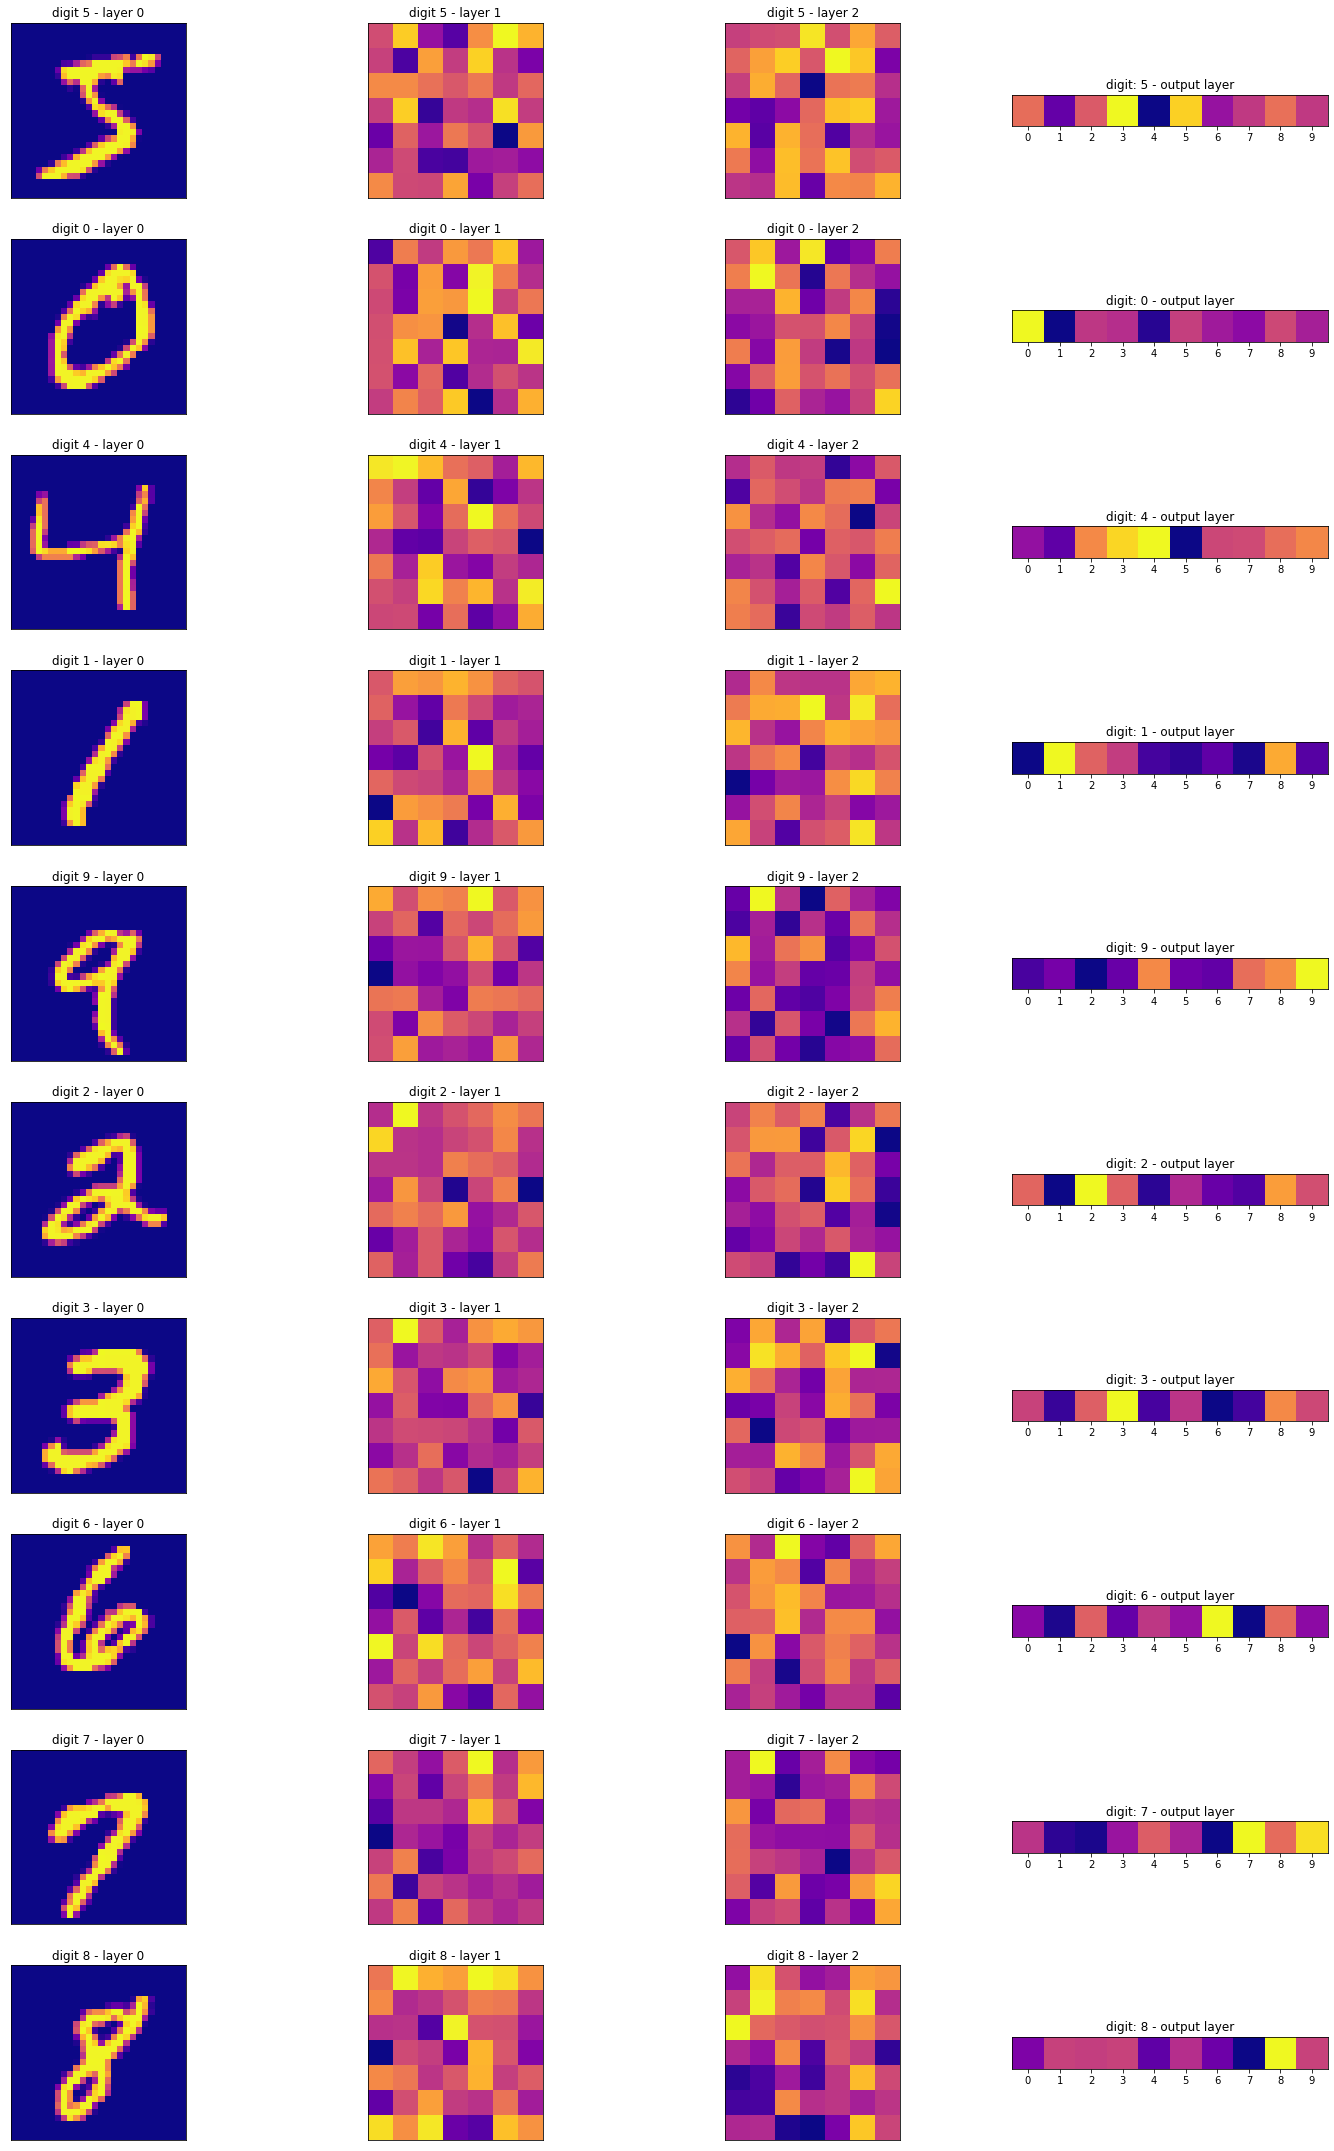

In [9]:
fig, axs = plt.subplots(figsize=(20, 30), nrows=10, ncols=4)
fig.tight_layout(h_pad=2)

for i, d in enumerate(numbers):
    objs = [images[i]]
    objs += activations[str(d)]

    for j, ax_, vector in zip(range(len(objs[:-1])), axs[i, :-1], objs[:-1]):
        if j == 0:
            ax_.imshow(vector.cpu().numpy().reshape(vector.size()[-2], vector.size()[-1]), 
                   cmap='plasma')
        else:
            ax_.imshow(vector.cpu().numpy().reshape(int(np.sqrt(vector.size()[-1])), 
                                                    int(np.sqrt(vector.size()[-1]))), 
                   cmap='plasma')
        ax_.set_title(f'digit {d} - layer {j}')
        ax_.set_xticks(())
        ax_.set_yticks(())

    axs[i, -1].imshow(objs[-1].cpu().numpy().reshape(1, 10), cmap='plasma')
    axs[i, -1].set_title(f'digit: {d} - output layer')
    axs[i, -1].set_xticks(range(10))
    axs[i, -1].set_yticks(())

plt.show()

## **How distributed are the "fixed points" ?**




### ***Qualitative Analysis***

divide data in classes

In [10]:
data = {}
for u in range(10):
    data[str(u)] = []

for idx, digit in enumerate(train_loader.dataset.targets):
    data[str(digit.numpy())].append(
        torchvision.transforms.functional.to_tensor(
            train_loader.dataset.data[idx].numpy()).unsqueeze(0))

for u in range(10):
    print(f'\n{u}: digit stored', len(data[str(u)]))


0: digit stored 5923

1: digit stored 6742

2: digit stored 5958

3: digit stored 6131

4: digit stored 5842

5: digit stored 5421

6: digit stored 5918

7: digit stored 6265

8: digit stored 5851

9: digit stored 5949


*quick check*

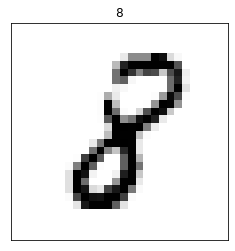

In [11]:
number = '8'
for i, img in enumerate(data[number]):
    plt.clf()
    plt.imshow(img.numpy().reshape(28, 28), cmap='Greys')
    plt.title(number)
    plt.xticks(())
    plt.yticks(())
    plt.pause(0.1)
    clear_output(wait=True)

    if i == 20: break

*get the matrix of means and stdv for one class*

In [12]:
def matrix_mean_stdv(class_images, model, shapes=(49, 49, 10)):

    ''' 
    given a model, obtain for each node of each layer the average activation
    over all the images of the same class.

    return: dict{ hid1: vector(means_hid1, stdvs_hid1), 
                  hid2: vector(means_hid2, stdvs_hid2),
                  out:  vector(means_out, stdvs_out))
    '''
     
    # activation matrix for each layer
    hid1 = np.zeros((shapes[0], len(class_images)))
    hid2 = np.zeros((shapes[1], len(class_images)))
    out = np.zeros((shapes[2], len(class_images)))

    # filling the matrices
    with torch.no_grad():
        for i, img in enumerate(class_images):
            _ = model.forward(x=Variable(img.cuda()), record=True)

            # record
            hid1[:, i] = model.activations[0].cpu().numpy()
            hid2[:, i] = model.activations[1].cpu().numpy()
            out[:, i] = model.activations[2].cpu().numpy()

    # get mu and stdv vectors
    mu1 = np.mean(hid1, axis=1).reshape(shapes[0], 1)
    hid1 = np.concatenate((mu1, np.std(hid1, axis=1).reshape(shapes[0], 1)), axis=1)
    
    mu1 = np.mean(hid2, axis=1).reshape(shapes[1], 1)
    hid2 = np.concatenate((mu1, np.std(hid2, axis=1).reshape(shapes[1], 1)), axis=1)

    mu1 = np.mean(out, axis=1).reshape(shapes[2], 1)
    out = np.concatenate((mu1, np.std(out, axis=1).reshape(shapes[2], 1)), axis=1)

    return {'L0': hid1,
            'L1': hid2,
            'L2': out}

In [13]:
help(matrix_mean_stdv)

Help on function matrix_mean_stdv in module __main__:

matrix_mean_stdv(class_images, model, shapes=(49, 49, 10))
    given a model, obtain for each node of each layer the average activation
    over all the images of the same class.
    
    return: dict{ hid1: vector(means_hid1, stdvs_hid1), 
                  hid2: vector(means_hid2, stdvs_hid2),
                  out:  vector(means_out, stdvs_out))



*repeat for each class*

In [14]:
C_1_mu = np.zeros((shapes[0], 10))
C_2_mu = np.zeros((shapes[1], 10))
C_3_mu = np.zeros((10, 10))

C_1_sigma = np.zeros((shapes[0], 10))
C_2_sigma = np.zeros((shapes[1], 10))
C_3_sigma = np.zeros((10, 10))

for number in range(10):
    print(f'processing class {number}')
    
    mean_stdv = matrix_mean_stdv(class_images=data[str(number)], model=ann, shapes=shapes)
    
    C_1_mu[:, number] = mean_stdv['L0'][:, 0]
    C_2_mu[:, number] = mean_stdv['L1'][:, 0]
    C_3_mu[:, number] = mean_stdv['L2'][:, 0]

    C_1_sigma[:, number] = mean_stdv['L0'][:, 1]
    C_2_sigma[:, number] = mean_stdv['L1'][:, 1]
    C_3_sigma[:, number] = mean_stdv['L2'][:, 1]

    clear_output(wait=True)

C_all_mu = [C_1_mu, C_2_mu, C_3_mu]
C_all_sigma = [C_1_sigma, C_2_sigma, C_3_sigma]

print('C_all_mu structure: [layer (1, 2, 3), matrix [layer_dim * n_classes]]')


C_all_mu structure: [layer (1, 2, 3), matrix [layer_dim * n_classes]]


**mean vector**

*average activation of the output layer for each class*

(it is as it should be)

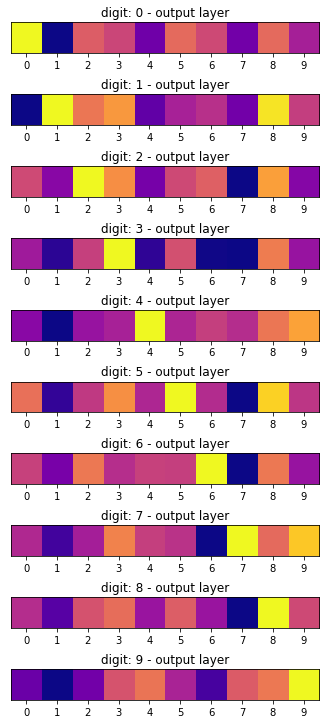

In [30]:
L = 2

fig, axs = plt.subplots(figsize=(15, 10), nrows=10)
fig.tight_layout(h_pad=2)

for number in range(10):
    axs[number].imshow(C_all_mu[L][:, number].reshape(1, C_all_mu[L][:, number].shape[0]), cmap='plasma')
    axs[number].set_title(f'digit: {number} - {layers_name[L]} layer')
    axs[number].set_xticks(range(10))
    axs[number].set_yticks(())

plt.show()

*first hidden layer*

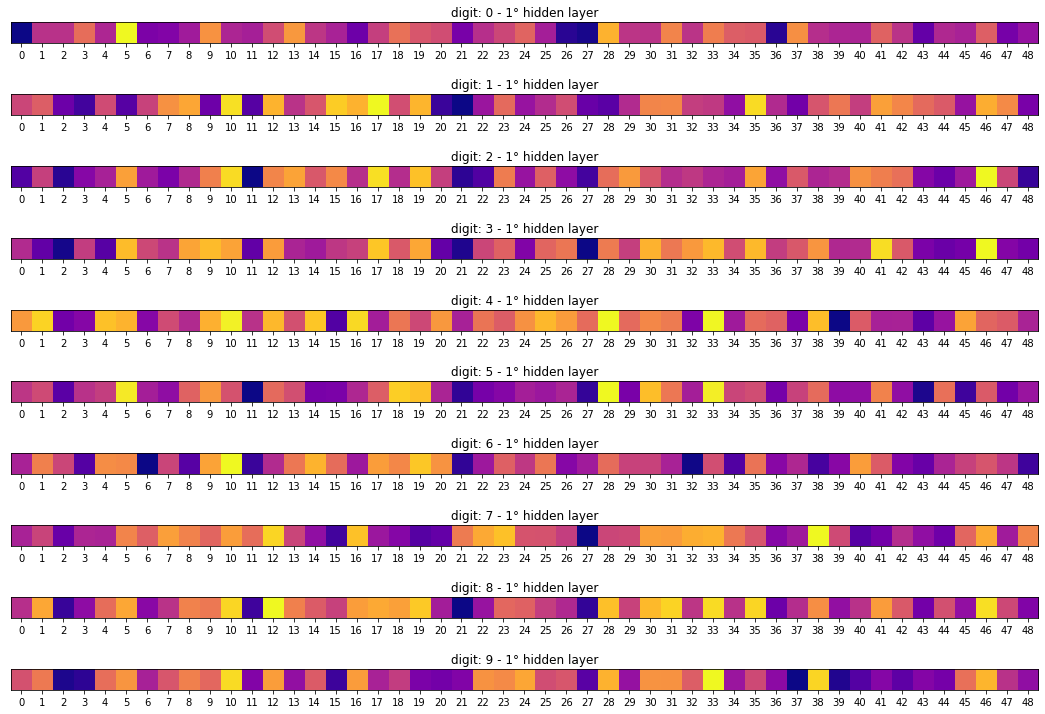

In [34]:
L = 0

fig, axs = plt.subplots(figsize=(15, 10), nrows=10)
fig.tight_layout(h_pad=2)

for number in range(10):
    axs[number].imshow(C_all_mu[L][:, number].reshape(1, C_all_mu[L][:, number].shape[0]), cmap='plasma')
    axs[number].set_title(f'digit: {number} - {L+1}° hidden layer')
    axs[number].set_xticks(range(C_all_mu[L][:, number].shape[0]))
    axs[number].set_yticks(())

plt.show()

*second hidden layer*

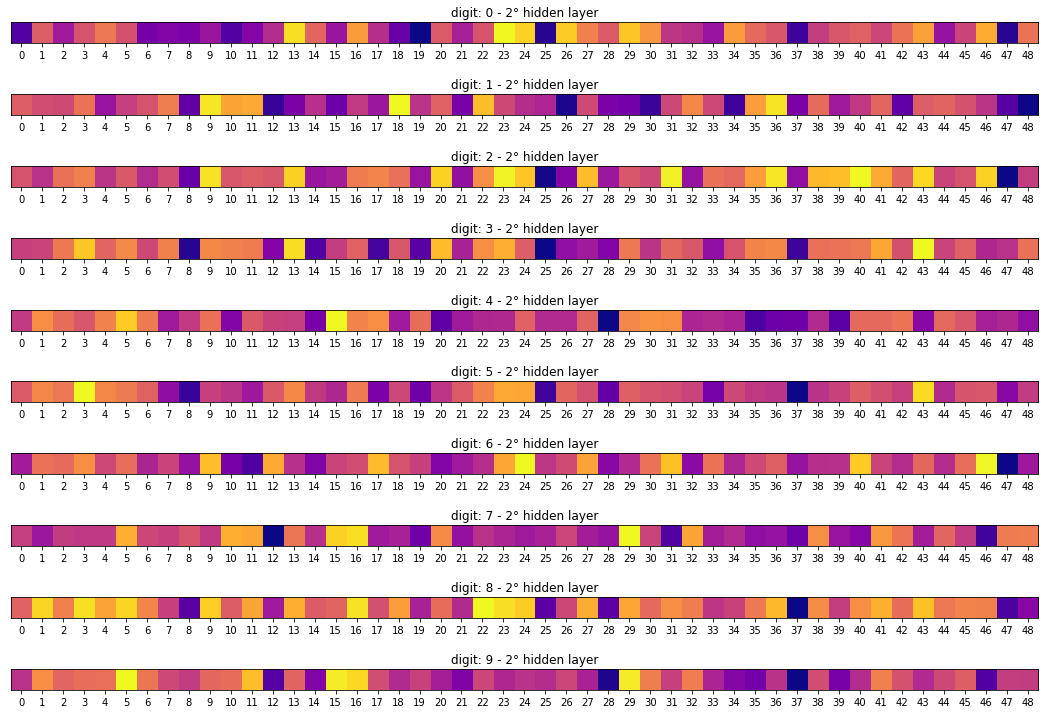

In [35]:
L = 1

fig, axs = plt.subplots(figsize=(15, 10), nrows=10)
fig.tight_layout(h_pad=2)

for number in range(10):
    axs[number].imshow(C_all_mu[L][:, number].reshape(1, C_all_mu[L][:, number].shape[0]), cmap='plasma')
    axs[number].set_title(f'digit: {number} - {L+1}° hidden layer')
    axs[number].set_xticks(range(C_all_mu[L][:, number].shape[0]))
    axs[number].set_yticks(())

plt.show()

**standard deviation vector**

*stdv of the output layer for each class*

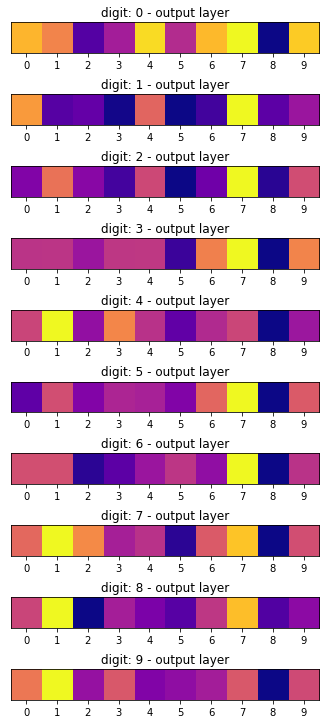

In [36]:
L = 2

fig, axs = plt.subplots(figsize=(15, 10), nrows=10)
fig.tight_layout(h_pad=2)

for number in range(10):
    axs[number].imshow(C_all_sigma[L][:, number].reshape(1, C_all_sigma[L][:, number].shape[0]), cmap='plasma')
    axs[number].set_title(f'digit: {number} - output layer')
    axs[number].set_xticks(range(10))
    axs[number].set_yticks(())

plt.show()

*for the first hidden*

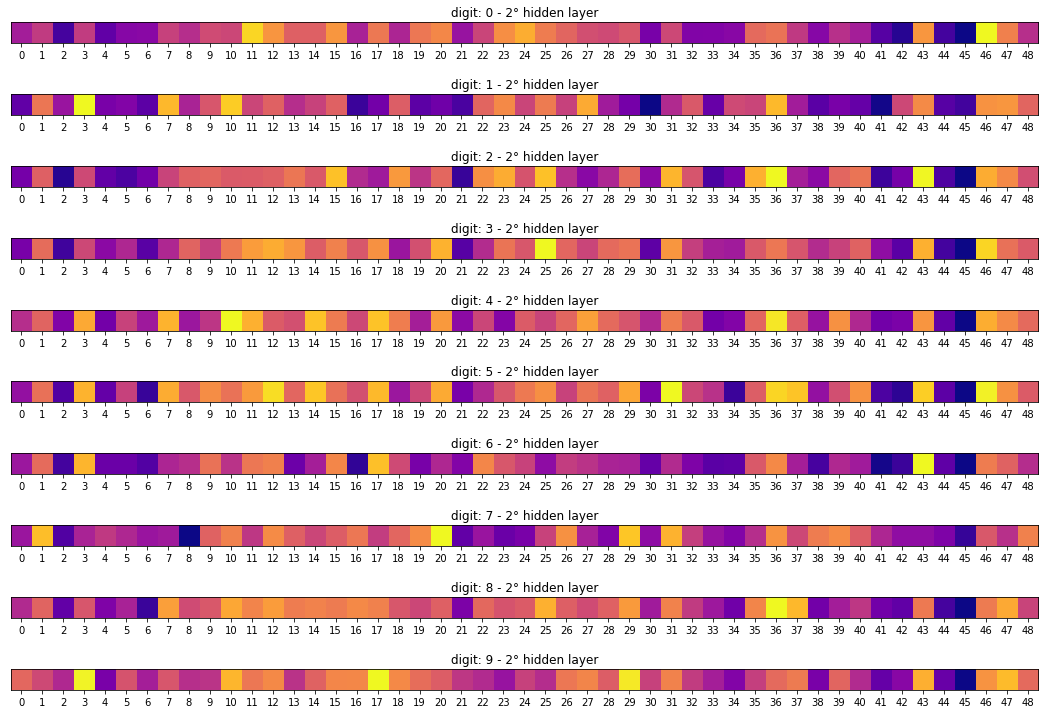

In [37]:
L = 1

fig, axs = plt.subplots(figsize=(15, 10), nrows=10)
fig.tight_layout(h_pad=2)

for number in range(10):
    axs[number].imshow(C_all_sigma[L][:, number].reshape(1, C_all_sigma[L][:, number].shape[0]), cmap='plasma')
    axs[number].set_title(f'digit: {number} - {L+1}° hidden layer')
    axs[number].set_xticks(range(C_all_mu[L][:, number].shape[0]))
    axs[number].set_yticks(())

plt.show()

*for the second hidden layer*

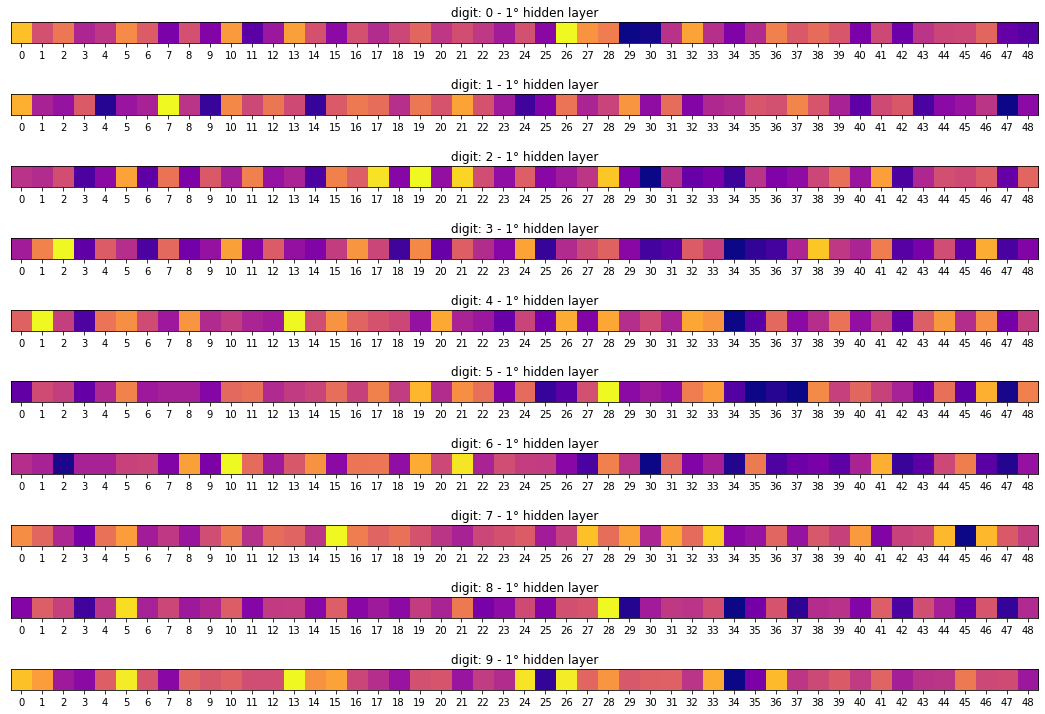

In [38]:
L = 0

fig, axs = plt.subplots(figsize=(15, 10), nrows=10)
fig.tight_layout(h_pad=2)

for number in range(10):
    axs[number].imshow(C_all_sigma[L][:, number].reshape(1, C_all_sigma[L][:, number].shape[0]), cmap='plasma')
    axs[number].set_title(f'digit: {number} - {L+1}° hidden layer')
    axs[number].set_xticks(range(C_all_mu[L][:, number].shape[0]))
    axs[number].set_yticks(())

plt.show()

**intra-class variability for each layer and class**

*mean and stdv of the stdv for each class*

In [15]:
S_mean = np.zeros((10, 3))
S_stdv = np.zeros((10, 3))

for l in range(len(shapes)):
    for c in range(10):
        S_mean[c, l] = np.mean(C_all_sigma[l][:, c])  # [layer][values, class]
        S_stdv[c, l] = np.std(C_all_sigma[l][:, c])

print('structure: n_classes * n_layers')

structure: n_classes * n_layers


**plot**

*mean across nodes of the across-inputs stdv*

- stdv of each layer's node (N total) across-inputs -> 1D stdv-vector: 1*N (across inputs stdv)
- mean of the stdv-vector -> 1*1 (across nodes)

*stdv across nodes of the across-inputs stdv*

- stdv of each layer's node (N total) across-inputs -> 1D stdv-vector: 1*N (across inputs stdv)
- stdv of the stdv-vector -> 1*1 (across nodes)

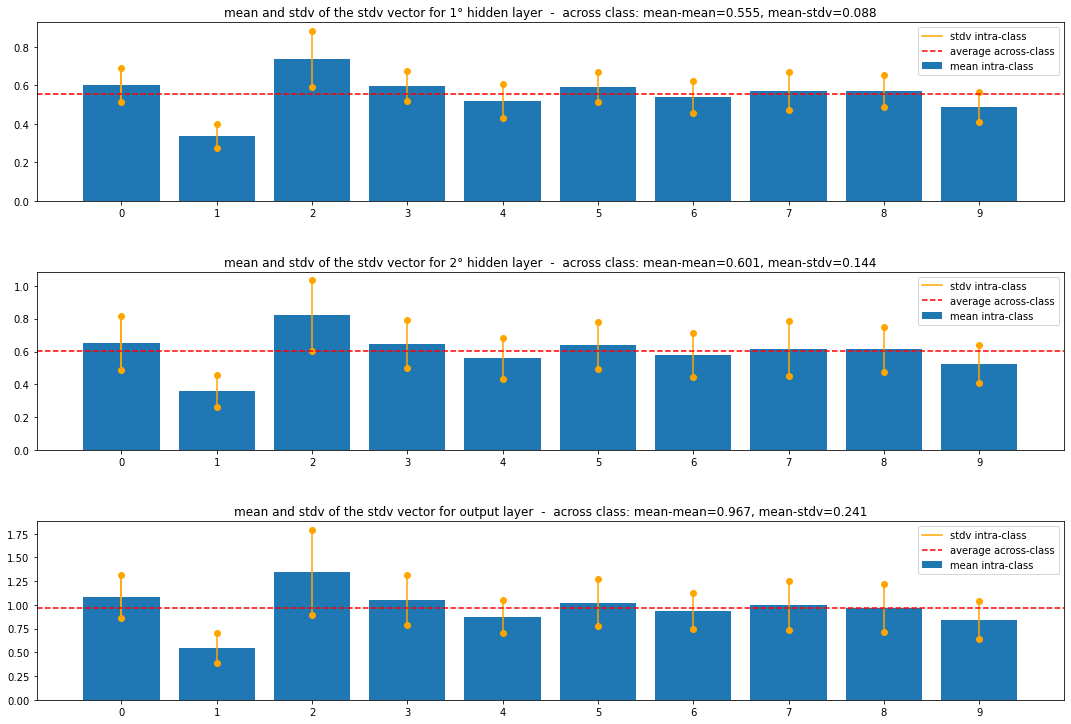

In [42]:
fig, axs = plt.subplots(figsize=(15, 10), nrows=3)
fig.tight_layout(h_pad=5)

for l in range(len(shapes)):
    # mean
    axs[l].bar(range(10), S_mean[:, l], label='mean intra-class')
    # stdv
    for o, mu, std in zip(range(10), S_mean[:, l], S_stdv[:, l]):
        if o == 0:
            axs[l].plot((o, o), (mu + std, mu - std), '-', color='orange', label='stdv intra-class')
        axs[l].plot((o, o), (mu + std, mu - std), '-', color='orange')
        axs[l].plot((o, o), (mu + std, mu - std), 'o', color='orange')
    # extra
    axs[l].set_title(f'mean and stdv of the stdv vector for {layers_name[l]} layer  ' + 
                     f'-  across class: mean-mean={np.mean(S_mean[:, l]):.3f}, mean-stdv={np.mean(S_stdv[:, l]):.3f}')
    axs[l].set_xticks(range(10))
    #axs[l].set_ylim((0, 1.7))

    axs[l].axhline(y=np.mean(S_mean[:, l]), color='red', linestyle='--', label='average across-class')
    axs[l].legend()

plt.show()

***2D visualization of the class-points***

- for each class, plot for two dimensions of the output layer of the across-inputs mean value, circled by the across-inputs standard deviation for those two dimensions

- in green the points whose belonging class is the same as the chosen axes - *As expected, when the classes that match the dimensions' index are well separated in space from the cluster of other values of non-matching values*

index of the layer to display
- L = 0  <- 1° hidden layer
- L = 1  <- 2° hidden layer
- L = 2  <- 3° output layer

output layer
 ---------------------------------------------------------------------------------------------------- 



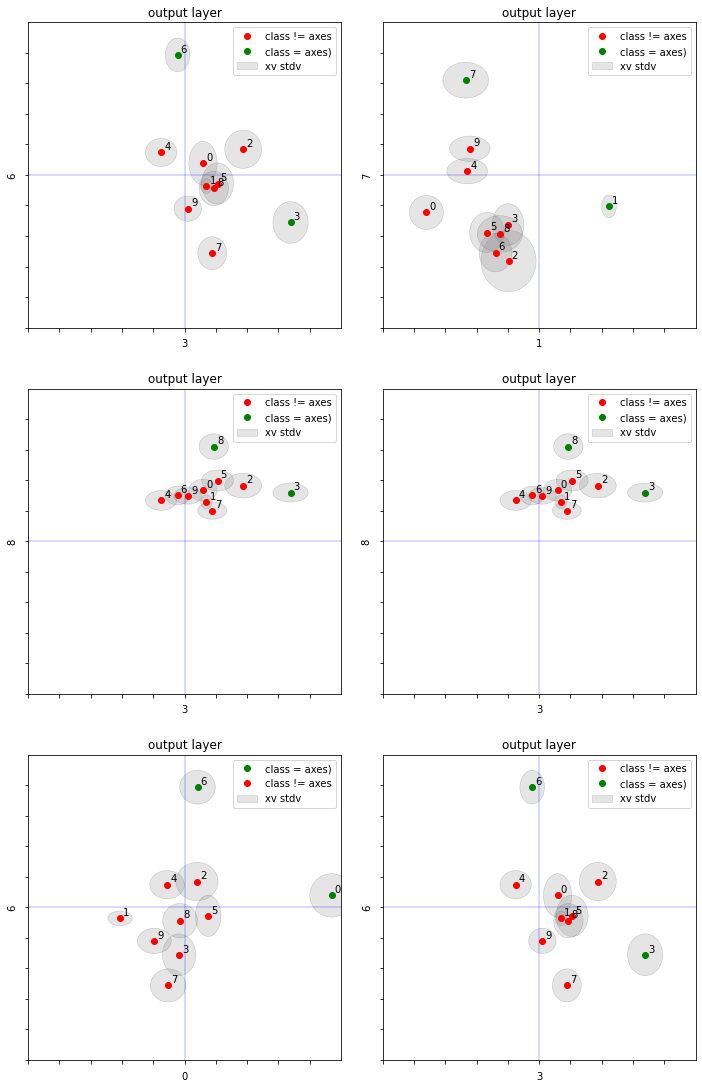

In [21]:
L = 2    

nr = 3  # °n of rows
nc = 2  # °n of columns


#########################################################################################################################


print(f'{layers_name[L]} layer\n', '-'*100, '\n')
fig, axs = plt.subplots(figsize=(10, 15), nrows=nr, ncols = nc)
fig.tight_layout(h_pad=4)

cmap = cm.get_cmap(name='rainbow')

for row in range(nr):
    for col in range(nc):

        mu_v = np.zeros((10, 2))
        stdv_v = np.zeros((10, 2))

        u1, u2 = np.random.randint(0, shapes[L]//2), np.random.randint(shapes[L]//2, shapes[L])
            
        axs[row][col].axhline(0, color='blue', alpha=0.2)
        axs[row][col].axvline(0, color='blue', alpha=0.2)

        go = True # for label
        
        # for each class n
        for n in range(10):
            # point location: mean
            mu_v[n, 0] = C_all_mu[L][u1, n]  # dim 1
            mu_v[n, 1] = C_all_mu[L][u2, n]  # dim 2

            # ellipse dims: axis-stdv
            stdv_v[n, 0] = C_all_sigma[L][u1, n]  # dim 1
            stdv_v[n, 1] = C_all_sigma[L][u2, n]  # dim 2

            if n == u1 or n == u2:
                if n == u1:
                    axs[row][col].plot(mu_v[n, 0], mu_v[n, 1], 'og', label='class = axes)')
                else:
                    axs[row][col].plot(mu_v[n, 0], mu_v[n, 1], 'og')
            else:
                if go:
                    axs[row][col].plot(mu_v[n, 0], mu_v[n, 1], 'or', label='class != axes')
                    go = False
                else:
                    axs[row][col].plot(mu_v[n, 0], mu_v[n, 1], 'or')

        for n, x, y in zip(range(10), mu_v[:, 0], mu_v[:, 1]):
            axs[row][col].annotate(f'{n}', xy=(x+0.1, y+0.1), textcoords='data')
            if n == 0:
                ellipse = Ellipse((x, y), width=stdv_v[n, 0], height=stdv_v[n, 1], facecolor='grey', alpha=0.2, 
                              edgecolor='black',linestyle='-',linewidth='0.5', label='xv stdv')
            else:
                ellipse = Ellipse((x, y), width=stdv_v[n, 0], height=stdv_v[n, 1], facecolor='grey', alpha=0.2, 
                              edgecolor='black',linestyle='-',linewidth='0.5')
            
            axs[row][col].add_patch(ellipse)
            axs[row][col].plot()
            axs[row][col].grid()
            

        #axs[row][col].plot(0, 0, '^k')

        axs[row][col].set_title(f'{layers_name[L]} layer')
        axs[row][col].set_xlabel(f'{u1}')
        axs[row][col].set_ylabel(f'{u2}')

        axs[row][col].set_yticks(range(-5, 5))
        axs[row][col].set_yticklabels(())
        axs[row][col].set_ylim((-5, 5))

        axs[row][col].set_xticks(range(-5, 5))
        axs[row][col].set_xticklabels(())
        axs[row][col].set_xlim((-5, 5))
        
        axs[row][col].legend()

plt.show()

# **Quantitative Analysis**

calculation of how *fixed* are the points

In [48]:
# each layer: transpose of the layer mean/stdv vector C_mu  ->  classes * nodes
Q_all_mu = [np.transpose(layer) for layer in C_all_mu]
Q_all_sigma = [np.transpose(layer) for layer in C_all_sigma]
print('Q_all_mu shape for one hidden layer: ', Q_all_mu[0].shape)

# each layer: column-wise mean/stdv of Q for all classes  ->  1 * nodes
S_all_Qmu = [np.mean(layer, axis=0) for layer in Q_all_mu]
S_all_Qsigma = [np.std(layer, axis=0) for layer in Q_all_mu]
print('\nS_all_Qmu shape for one hidden layer: ', S_all_Qmu[0].shape)

# each layer: z-score for each class  ->  1 * nodes
Z_all_zmu = []

# for all layers
for L in range(len(shapes)):
    Z_l = np.zeros((10, shapes[L]))
    # for all mean, stdv of each node
    for n, mu, sigma in zip(range(shapes[L]), S_all_Qmu[L], S_all_Qsigma[L]):
        # for each class value for node n
        for c in range(10):
            x = Q_all_mu[L][c, n]
            Z_l[c, n] = (x - mu)/sigma

    Z_all_zmu.append(Z_l)

print('\nZ_all_zmu shape for one hidden layer: ', Z_all_zmu[0].shape)

def f_score(k, L, axes=(0, 1)):

    ''' f-score for the k-th class '''

    # across-inputs mean for layer L, class k and for certain axes/nodes
    q_mu = Q_all_mu[L][k, axes[0]: axes[1]]

    # across-inputs stdv for layer L, class k and for certain axes/nodes
    q_stdv = Q_all_sigma[L][k, axes[0]: axes[1]]

    # coefficient of variation of the k-th class: cv = stdv/mean
    cv_k = q_stdv / q_mu
    
    # z-score of q_mu (z-score of the k-th class respect to the others)
    z_k = Z_all_zmu[L][k, axes[0]: axes[1]]

    # f-score
    f_k = z_k / cv_k

    return f_k
    
print()

Q_all_mu shape for one hidden layer:  (10, 49)

S_all_Qmu shape for one hidden layer:  (49,)

Z_all_zmu shape for one hidden layer:  (10, 49)



In [49]:
def softmax(s):
    return np.array([np.exp(s[k]) / np.sum(np.exp(s)) for k in range(max(s.shape))])

computation of the F-scores

In [50]:
F_scores = []
F_scores_sf = []

# for each layer
for L in range(len(shapes)):
    f_score_class = np.zeros((10, shapes[L]))
    f_score_class_sf = np.zeros((10, shapes[L]))

    # for each class
    for k in range(10):
        f_score_class[k, :] = f_score(k=k, L=L, axes=(0, shapes[L]))
        #print(f'\nlayer {L}\nclass {k}\nf-scores {np.around(f_score(k=k, L=L, axes=(0, shapes[L])), 2)}\nsoftmax {np.around(softmax(f_score(k=k, L=L, axes=(0, shapes[L]))), 2)}')
        f_score_class_sf[k, :] = softmax(f_score(k=k, L=L, axes=(0, shapes[L])))

    # softmax
    F_scores_sf.append(f_score_class_sf)
    
    # standardization
    f_score_class[np.isnan(f_score_class)] = 0
    f_score_class = (f_score_class - f_score_class.mean()) / f_score_class.std()

    F_scores.append(f_score_class)
print('f_scores acquired\n\n- finished -')

f_scores acquired

- finished -


### **plot 1:** *heatmap*

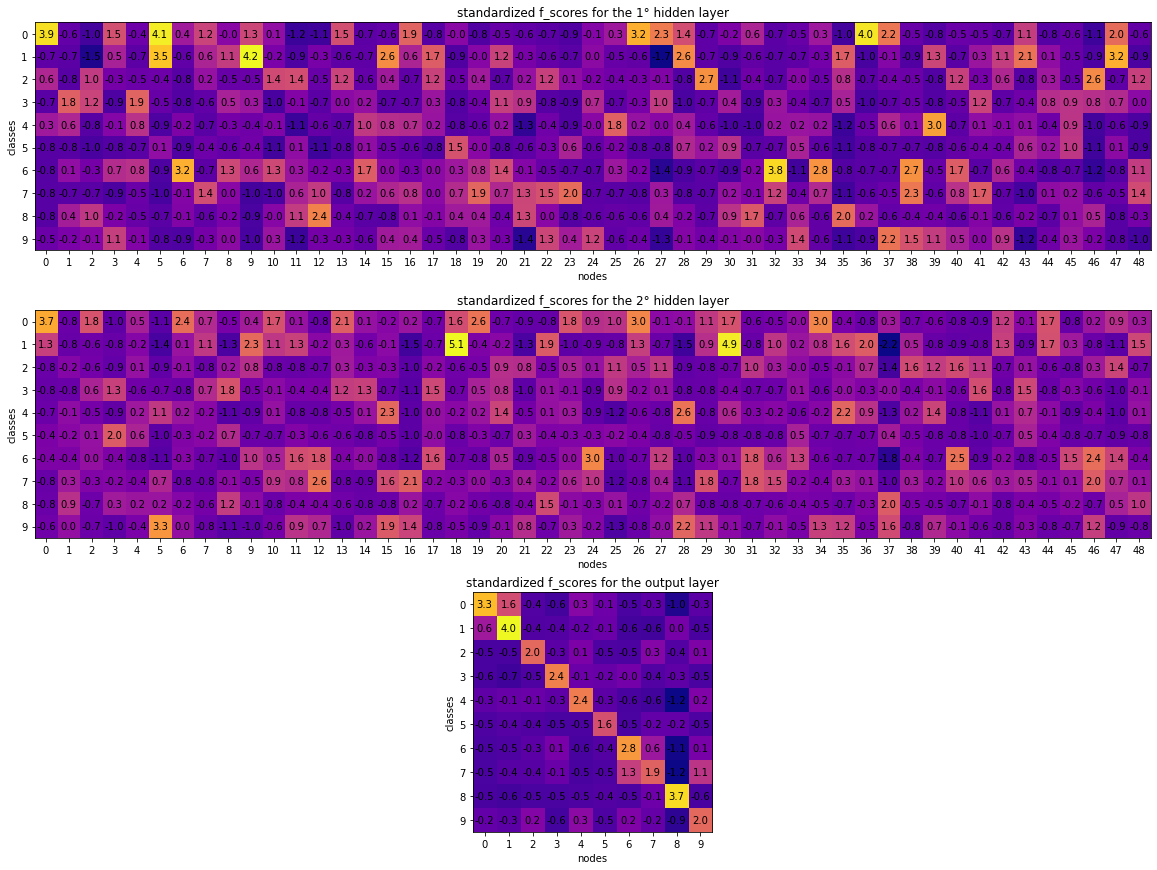

In [54]:
fig, axs = plt.subplots(figsize=(20, 15), nrows=3, ncols=1)

for L in range(3):
    axs[L].imshow(F_scores[L], cmap='plasma')
    axs[L].set_xlabel('nodes')
    axs[L].set_xticks(range(shapes[L]))

    axs[L].set_ylabel('classes')
    axs[L].set_yticks(range(10))
    axs[L].set_title(f'standardized f_scores for the {layers_name[L]} layer')

    for (i, j), f in np.ndenumerate(F_scores[L]):
        axs[L].text(j, i, f'{f:.1f}', ha='center', va='center')


plt.show()

#### softmax of the f_scores

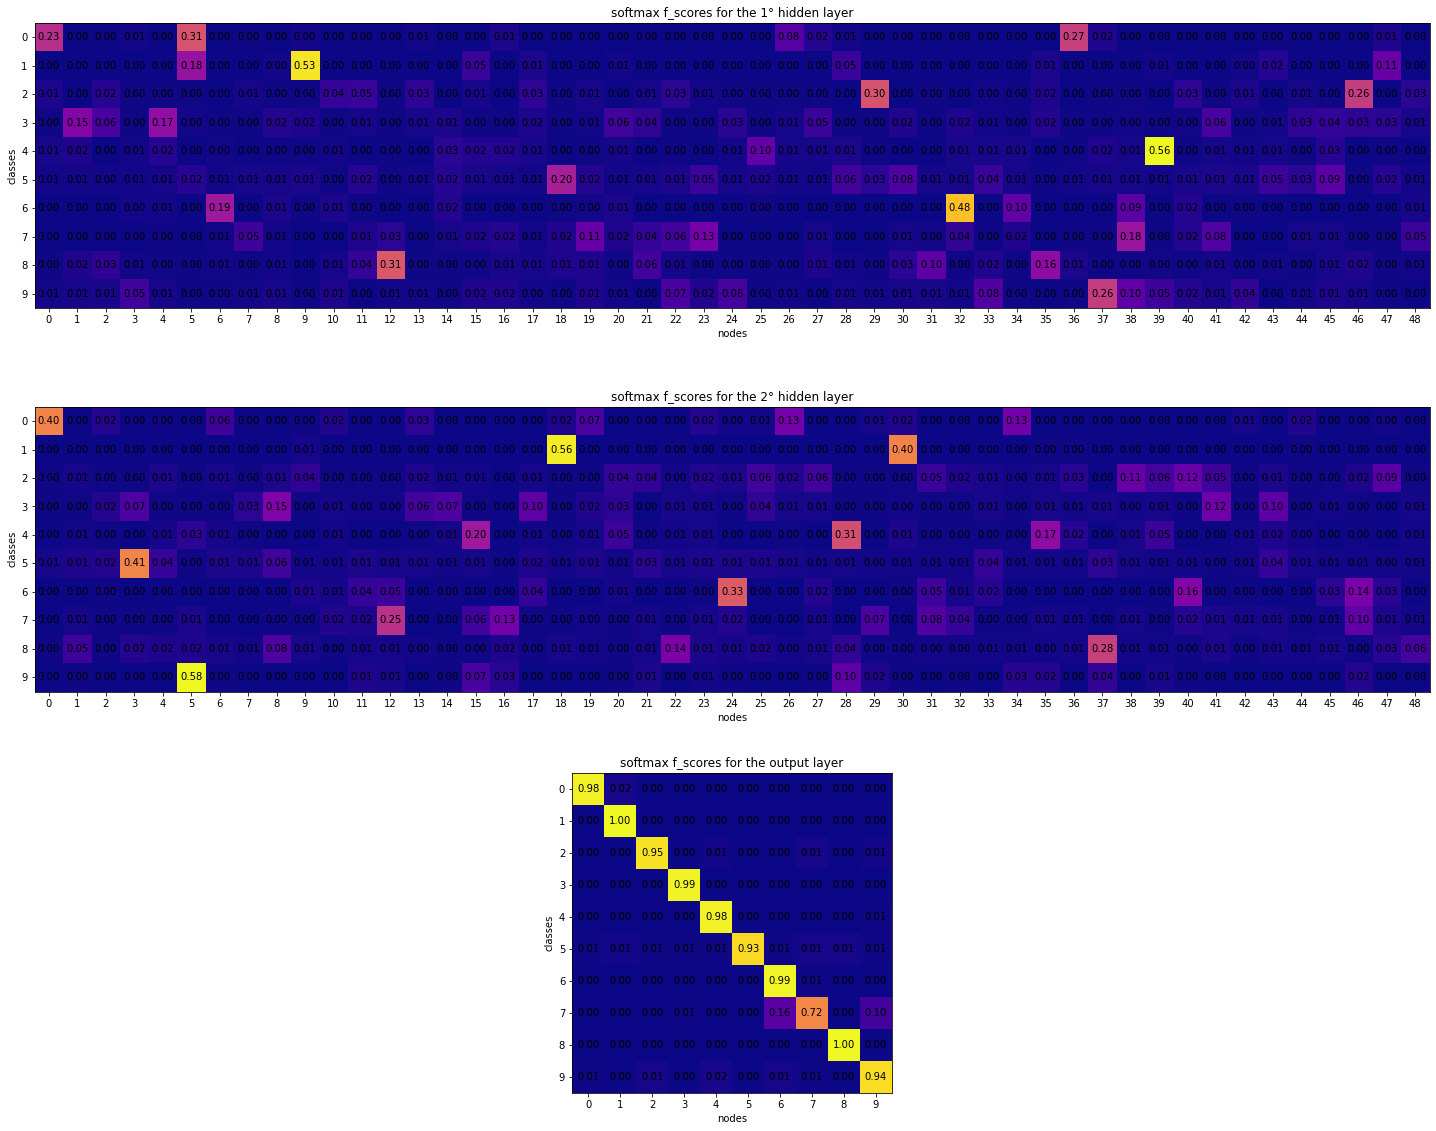

In [55]:
fig, axs = plt.subplots(figsize=(25, 20), nrows=3, ncols=1)

for L in range(3):
    axs[L].imshow(F_scores_sf[L], cmap='plasma')
    axs[L].set_xlabel('nodes')
    axs[L].set_xticks(range(shapes[L]))

    axs[L].set_ylabel('classes')
    axs[L].set_yticks(range(10))
    axs[L].set_title(f'softmax f_scores for the {layers_name[L]} layer')

    for (i, j), f in np.ndenumerate(F_scores_sf[L]):
        axs[L].text(j, i, f'{f:.2f}', ha='center', va='center')


plt.show()

#### 2D representation
class mean-points and f-scores

output layer
 ---------------------------------------------------------------------------------------------------- 



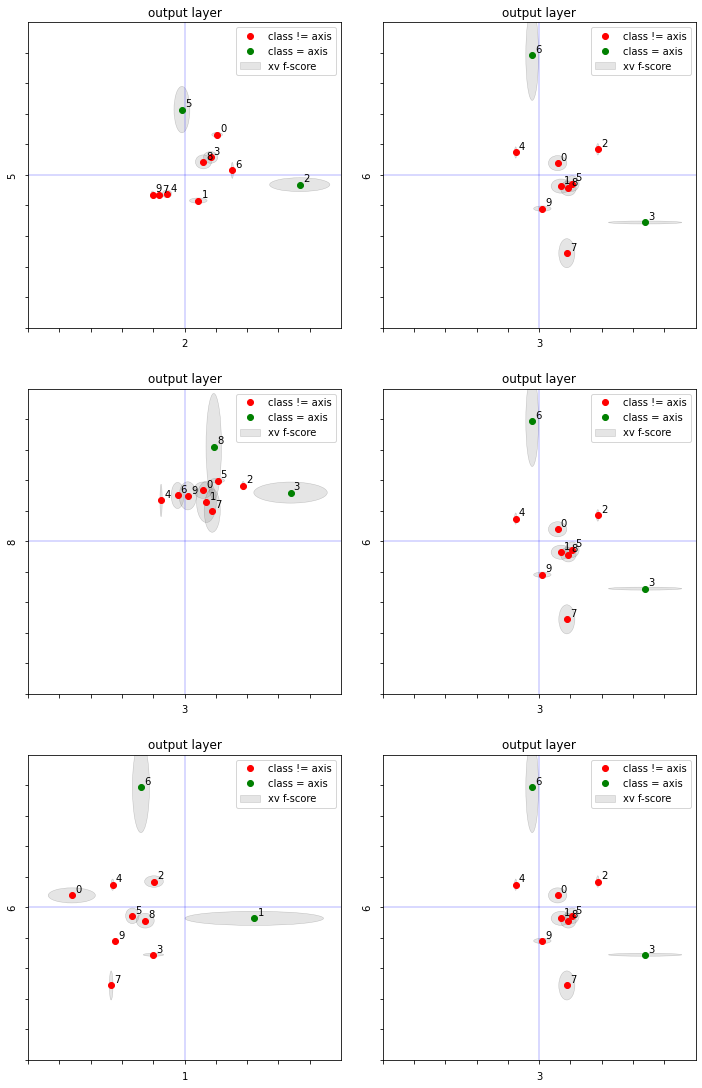

In [53]:
L = 2  # <- change as before 

nr = 3
nc = 2

##########################################################################################################################


print(f'{layers_name[L]} layer\n', '-'*100, '\n')
fig, axs = plt.subplots(figsize=(10, 15), nrows=nr, ncols = nc)
fig.tight_layout(h_pad=4)

cmap = cm.get_cmap(name='rainbow')

for row in range(nr):
    for col in range(nc):

        mu_v = np.zeros((10, 2))
        f_v = np.zeros((10, 2))

        u1, u2 = np.random.randint(0, shapes[L]//2), np.random.randint(shapes[L]//2, shapes[L])
            
        axs[row][col].axhline(0, color='blue', alpha=0.2)
        axs[row][col].axvline(0, color='blue', alpha=0.2)

        go = True
        # for each class k
        for k in range(10):
            # point location: mean
            mu_v[k, 0] = C_all_mu[L][u1, k]  # dim 1
            mu_v[k, 1] = C_all_mu[L][u2, k]  # dim 2

            # ellipse dims: axis-stdv
            f_v[k, 0] = F_scores[L][k, u1]  # dim 1
            f_v[k, 1] = F_scores[L][k, u2]  # dim 2

            if k == u1 or k == u2:
                if k == u1:
                    axs[row][col].plot(mu_v[k, 0], mu_v[k, 1], 'og', label='class = axis')
                else:
                    axs[row][col].plot(mu_v[k, 0], mu_v[k, 1], 'og')
            else:
                if go:
                    axs[row][col].plot(mu_v[k, 0], mu_v[k, 1], 'or', label='class != axis')
                    go = False
                else:
                    axs[row][col].plot(mu_v[k, 0], mu_v[k, 1], 'or')

        for k, x, y in zip(range(10), mu_v[:, 0], mu_v[:, 1]):
            axs[row][col].annotate(f'{k}', xy=(x+0.1, y+0.1), textcoords='data')
            if k == 0:
                ellipse = Ellipse((x, y), width=f_v[k, 0], height=f_v[k, 1], facecolor='grey', alpha=0.2, 
                              edgecolor='black',linestyle='-',linewidth='0.5', label='xv f-score')
            else:
                ellipse = Ellipse((x, y), width=f_v[k, 0], height=f_v[k, 1], facecolor='grey', alpha=0.2, 
                              edgecolor='black',linestyle='-',linewidth='0.5')
            
            axs[row][col].add_patch(ellipse)
            axs[row][col].plot()
            axs[row][col].grid()

        #axs[row][col].plot(0, 0, '^k')

        axs[row][col].set_title(f'{layers_name[L]} layer')
        axs[row][col].set_xlabel(f'{u1}')
        
        axs[row][col].set_ylabel(f'{u2}')

        axs[row][col].set_yticks(range(-5, 5))
        axs[row][col].set_yticklabels(())
        axs[row][col].set_ylim((-5, 5))

        axs[row][col].set_xticks(range(-5, 5))
        axs[row][col].set_xticklabels(())
        axs[row][col].set_xlim((-5, 5))
        
        axs[row][col].legend()

plt.show()

## ANN plain binarizarion -> BNN

##### binarization

In [22]:
def binarization(x, bias=0, zero=1):
    if zero:
        return 1 if x >= bias else -1
    else:
        return 1 if x > bias else -1
    
binarization = np.vectorize(binarization)

In [23]:
# new network
bnn = Net(n_hid_1=shapes[0], n_hid_2=shapes[1], lr=lr, binary=True)
bnn = bnn.cuda()

# copy and binarized the weights from the original ANN
with torch.no_grad():
    for param_b, param_a in zip(bnn.state_dict(), ann.state_dict()):
        bnn.state_dict()[param_b][:, :] = torch.Tensor(binarization(ann.state_dict()[param_a].cpu(), bias=0.0, zero=True)).cuda()
        
print('binarized!')
print(f'\nANN accuracy: {ann.test():.1f}%\nBNN accuracy: {bnn.test():.1f}%')

binarized!

ANN accuracy: 91.9%
BNN accuracy: 32.1%


**Try different bounds on the integer-valued activation vectors of the BNN** 

as expected, more generous bound provide better performance

- finished -


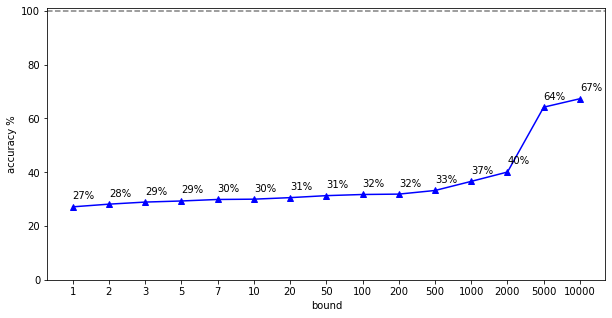

In [77]:
bounds = [1, 2, 3, 5, 7, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
accs = np.zeros(len(bounds))

for i, bound in enumerate(bounds):
    print(f'tested {i/len(bounds)*100:.1f}%')
    bnn.bound = bound
    accs[i] = bnn.test()
    clear_output(wait=True)
    
print('- finished -')

plt.figure(figsize=(10, 5))
plt.plot(range(len(bounds)), accs, '-b')
plt.plot(range(len(bounds)), accs, '^b')

plt.xlabel('bound')
plt.ylabel('accuracy %')
plt.ylim((0, 101))
plt.axhline(100, color='grey', linestyle='--')

for n, x, y in zip(range(len(bounds)), range(len(bounds)), accs):
    plt.annotate(f'{y:.0f}%', xy=(x, y+3), textcoords='data')
        
plt.xticks(range(len(bounds)), bounds)
plt.show()

In [34]:
# set bound
bnn.bound = 1

### layer activation visualization

In [35]:
activationsB = {}
with torch.no_grad():
    for digit, image in zip(numbers, images):
        image = Variable(image.cuda())
        _ = bnn.forward(x=image, record=True)
        activationsB[str(digit)] = bnn.activations

print(f'activations: {len(activationsB)}\n\n- finished -\n')

activations: 10

- finished -



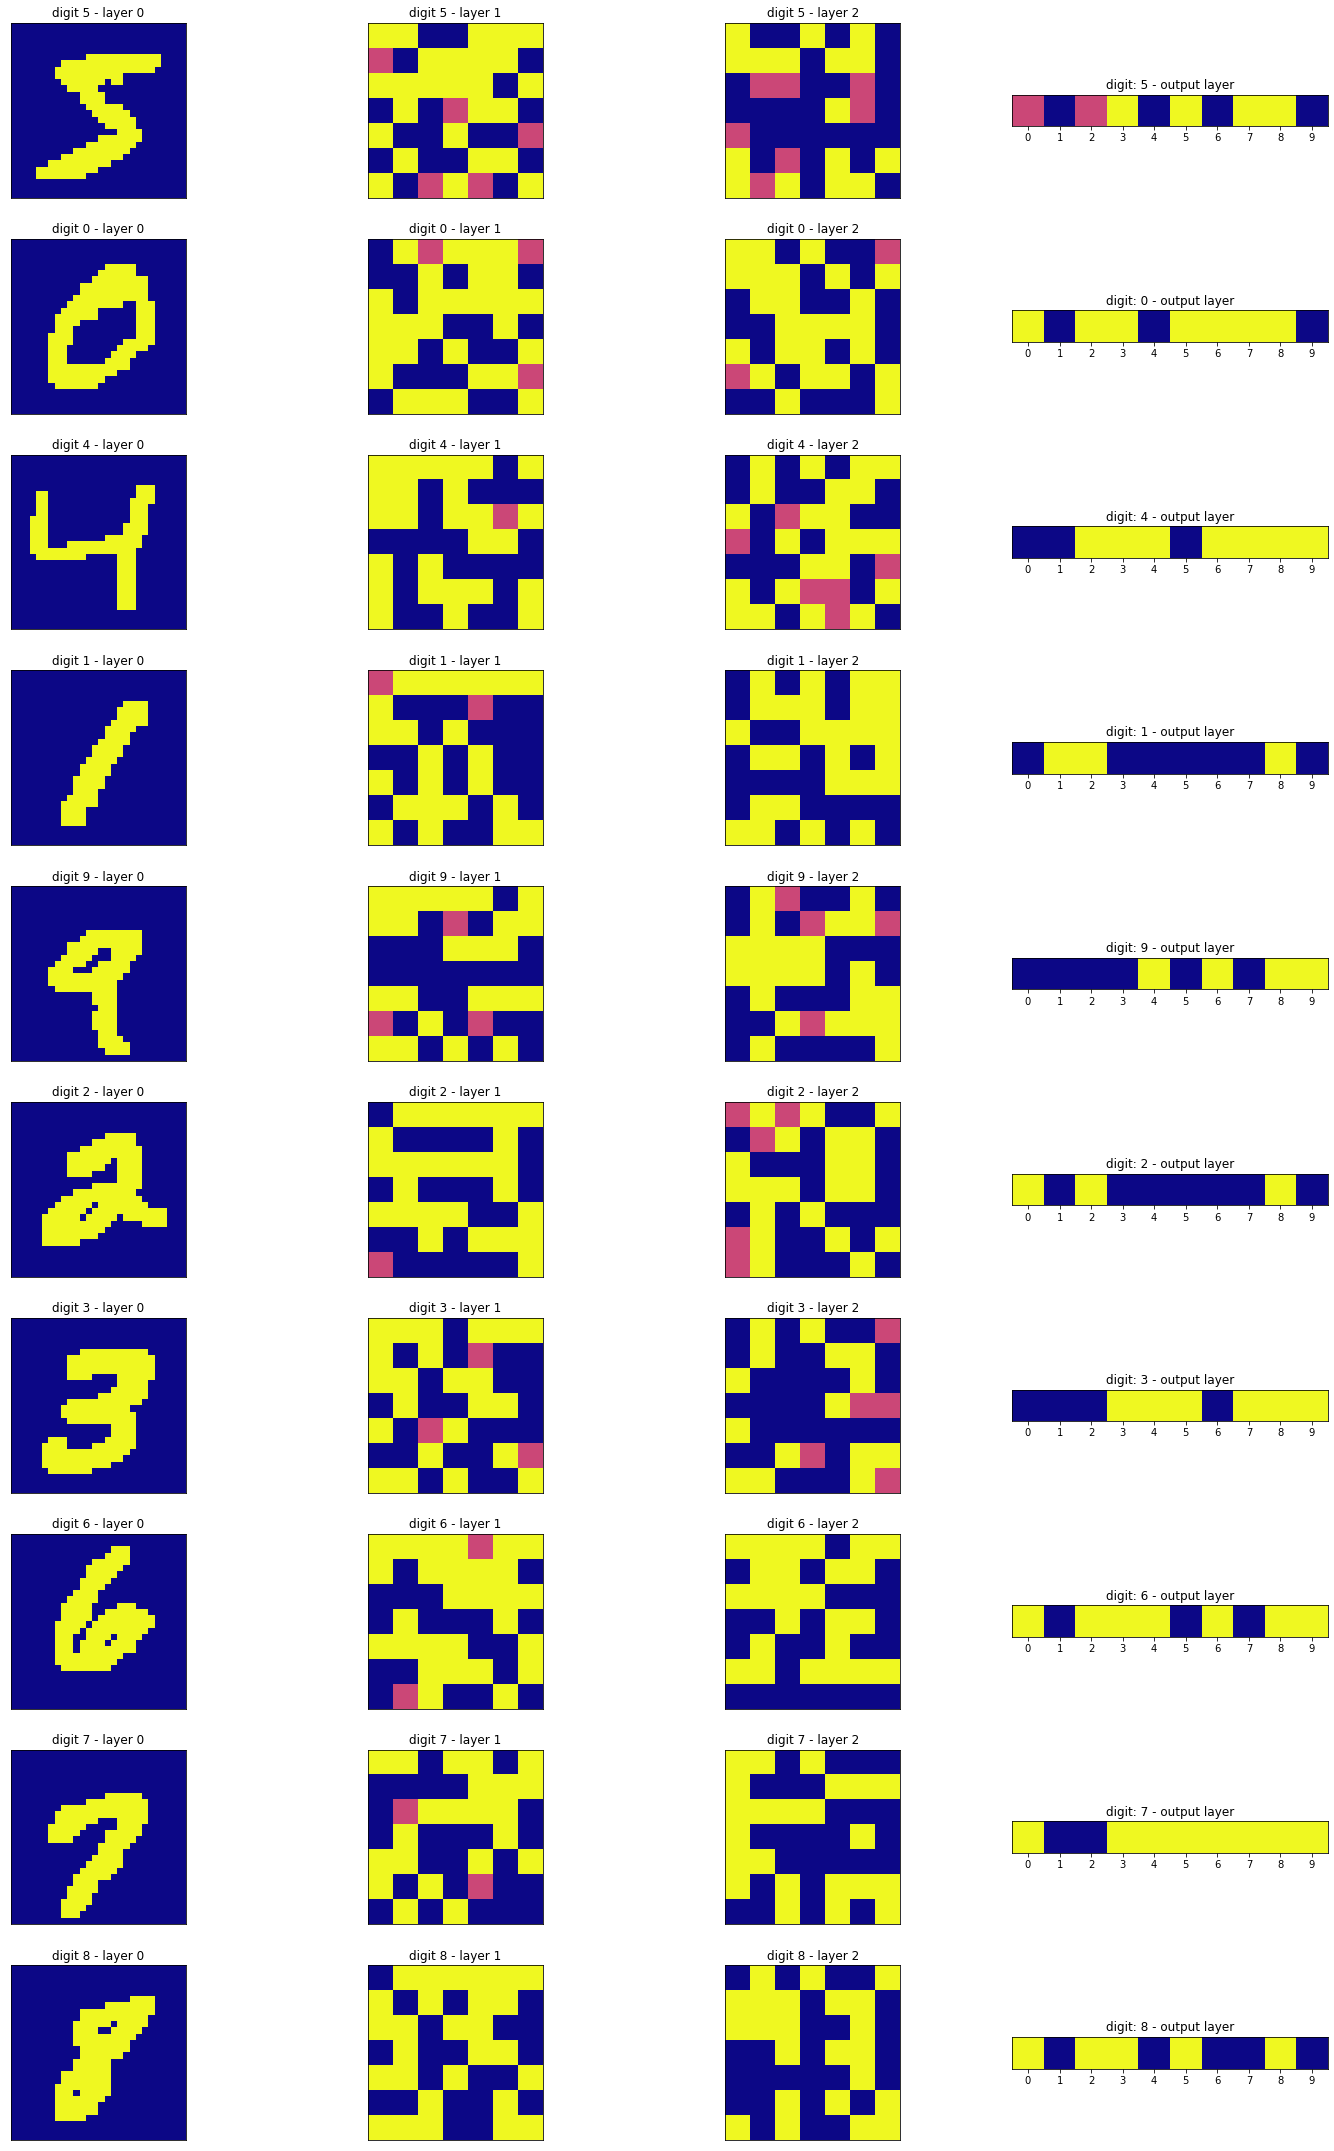

In [36]:
fig, axs = plt.subplots(figsize=(20, 30), nrows=10, ncols=4)
fig.tight_layout(h_pad=2)

for i, d in enumerate(numbers):
    objs = [torch.heaviside(images[i], torch.zeros(1))]
    objs += activationsB[str(d)]

    for j, ax_, vector in zip(range(len(objs[:-1])), axs[i, :-1], objs[:-1]):
        if j == 0:
            ax_.imshow(vector.cpu().numpy().reshape(vector.size()[-2], vector.size()[-1]), 
                   cmap='plasma')
        else:
            ax_.imshow(vector.cpu().numpy().reshape(int(np.sqrt(vector.size()[-1])), 
                                                    int(np.sqrt(vector.size()[-1]))), 
                   cmap='plasma')
        ax_.set_title(f'digit {d} - layer {j}')
        ax_.set_xticks(())
        ax_.set_yticks(())

    axs[i, -1].imshow(objs[-1].cpu().numpy().reshape(1, 10), cmap='plasma')
    axs[i, -1].set_title(f'digit: {d} - output layer')
    axs[i, -1].set_xticks(range(10))
    axs[i, -1].set_yticks(())

plt.show()

## qualitative analysis - fixed points

In [37]:
C_1_muB = np.zeros((shapes[0], 10))
C_2_muB = np.zeros((shapes[1], 10))
C_3_muB = np.zeros((10, 10))

C_1_sigmaB = np.zeros((shapes[0], 10))
C_2_sigmaB = np.zeros((shapes[1], 10))
C_3_sigmaB = np.zeros((10, 10))

for number in range(10):
    print(f'processing class {number}')
    
    mean_stdv = matrix_mean_stdv(class_images=data[str(number)], model=bnn, shapes=shapes)
    
    C_1_muB[:, number] = mean_stdv['L0'][:, 0]
    C_2_muB[:, number] = mean_stdv['L1'][:, 0]
    C_3_muB[:, number] = mean_stdv['L2'][:, 0]

    C_1_sigmaB[:, number] = mean_stdv['L0'][:, 1]
    C_2_sigmaB[:, number] = mean_stdv['L1'][:, 1]
    C_3_sigmaB[:, number] = mean_stdv['L2'][:, 1]

    clear_output(wait=True)

C_all_muB = [C_1_muB, C_2_muB, C_3_muB]
C_all_sigmaB = [C_1_sigmaB, C_2_sigmaB, C_3_sigmaB]

print('C_all_mu structure: [layer (1, 2, 3), matrix [layer_dim * n_classes]]')
print('\n- finished -')

C_all_mu structure: [layer (1, 2, 3), matrix [layer_dim * n_classes]]

- finished -


##### mean vectors

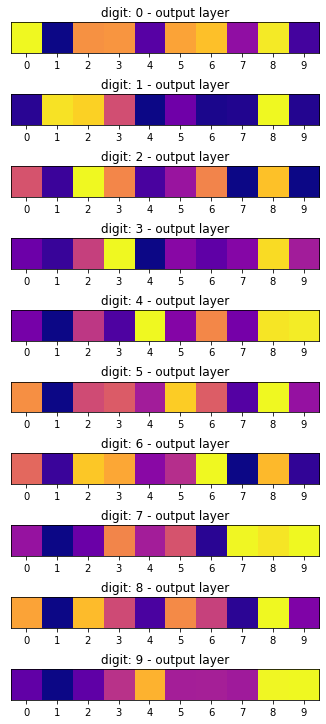

In [38]:
L = 2

fig, axs = plt.subplots(figsize=(15, 10), nrows=10)
fig.tight_layout(h_pad=2)

for number in range(10):
    axs[number].imshow(C_all_muB[L][:, number].reshape(1, C_all_muB[L][:, number].shape[0]), cmap='plasma')
    axs[number].set_title(f'digit: {number} - {layers_name[L]} layer')
    axs[number].set_xticks(range(10))
    axs[number].set_yticks(())

plt.show()

##### stdv vectors

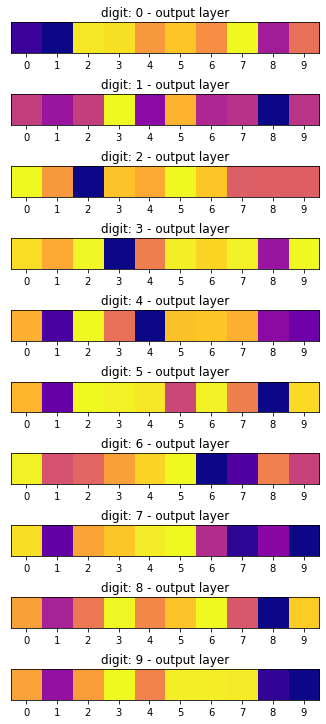

In [39]:
L = 2

fig, axs = plt.subplots(figsize=(15, 10), nrows=10)
fig.tight_layout(h_pad=2)

for number in range(10):
    axs[number].imshow(C_all_sigmaB[L][:, number].reshape(1, C_all_sigmaB[L][:, number].shape[0]), cmap='plasma')
    axs[number].set_title(f'digit: {number} - {layers_name[L]} layer')
    axs[number].set_xticks(range(10))
    axs[number].set_yticks(())

plt.show()

##### intra-class variability for each layer

In [40]:
S_meanB = np.zeros((10, 3))
S_stdvB = np.zeros((10, 3))

for l in range(len(shapes)):
    for c in range(10):
        S_meanB[c, l] = np.mean(C_all_sigmaB[l][:, c])  # [layer][values, class]
        S_stdvB[c, l] = np.std(C_all_sigmaB[l][:, c])

print('structure: n_classes * n_layers\n\n- finished -')

structure: n_classes * n_layers

- finished -


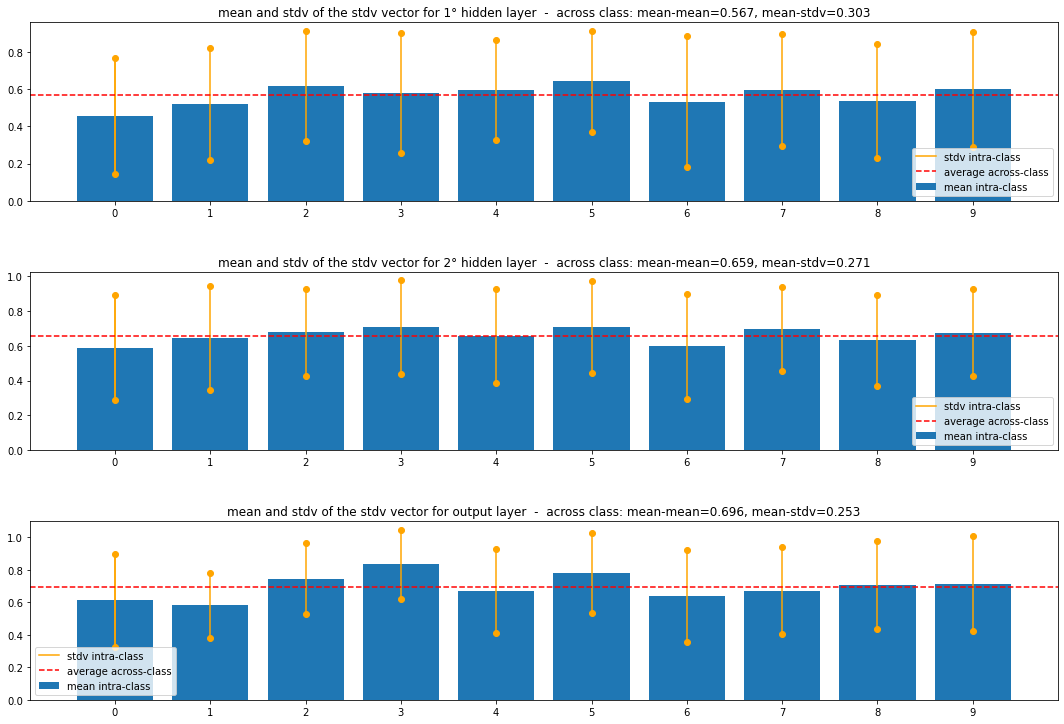

In [41]:
fig, axs = plt.subplots(figsize=(15, 10), nrows=3)
fig.tight_layout(h_pad=5)

for l in range(len(shapes)):
    # mean
    axs[l].bar(range(10), S_meanB[:, l], label='mean intra-class')
    # stdv
    for o, mu, std in zip(range(10), S_meanB[:, l], S_stdvB[:, l]):
        if o == 0:
            axs[l].plot((o, o), (mu + std, mu - std), '-', color='orange', label='stdv intra-class')
        axs[l].plot((o, o), (mu + std, mu - std), '-', color='orange')
        axs[l].plot((o, o), (mu + std, mu - std), 'o', color='orange')
    # extra
    axs[l].set_title(f'mean and stdv of the stdv vector for {layers_name[l]} layer  ' + 
                     f'-  across class: mean-mean={np.mean(S_meanB[:, l]):.3f}, mean-stdv={np.mean(S_stdvB[:, l]):.3f}')
    axs[l].set_xticks(range(10))
    #axs[l].set_ylim((0, 1.7))

    axs[l].axhline(y=np.mean(S_meanB[:, l]), color='red', linestyle='--', label='average across-class')
    axs[l].legend()

plt.show()

output layer
 ---------------------------------------------------------------------------------------------------- 



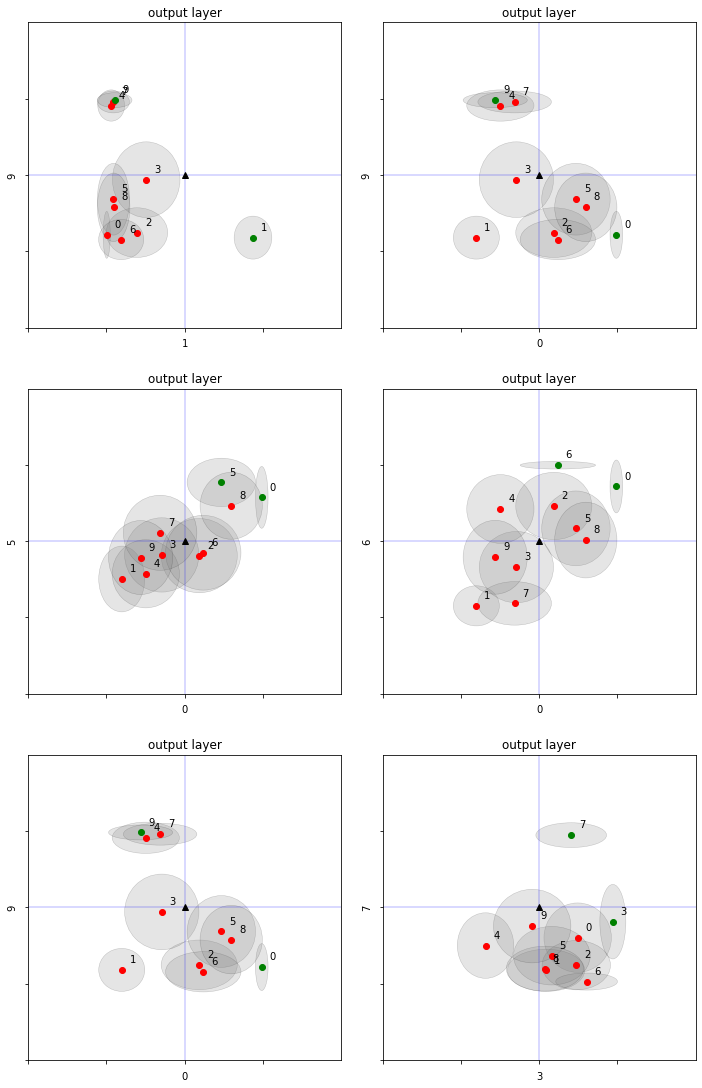

In [46]:
L = 2 
nr = 3
nc = 2

lim = 2


##########################################################################################################################


print(f'{layers_name[L]} layer\n', '-'*100, '\n')
fig, axs = plt.subplots(figsize=(10, 15), nrows=nr, ncols = nc)
fig.tight_layout(h_pad=4)

cmap = cm.get_cmap(name='rainbow')

for row in range(nr):
    for col in range(nc):

        mu_v = np.zeros((10, 2))
        stdv_v = np.zeros((10, 2))

        u1, u2 = np.random.randint(0, shapes[L]//2), np.random.randint(shapes[L]//2, shapes[L])
            
        axs[row][col].axhline(0, color='blue', alpha=0.2)
        axs[row][col].axvline(0, color='blue', alpha=0.2)

        # for each class n
        for n in range(10):
            # point location: mean
            mu_v[n, 0] = C_all_muB[L][u1, n]  # dim 1
            mu_v[n, 1] = C_all_muB[L][u2, n]  # dim 2

            # ellipse dims: axis-stdv
            stdv_v[n, 0] = C_all_sigmaB[L][u1, n]  # dim 1
            stdv_v[n, 1] = C_all_sigmaB[L][u2, n]  # dim 2

            if n == u1 or n == u2:
                axs[row][col].plot(mu_v[n, 0], mu_v[n, 1], 'og')
            else:
                axs[row][col].plot(mu_v[n, 0], mu_v[n, 1], 'or')

        for n, x, y in zip(range(10), mu_v[:, 0], mu_v[:, 1]):
            axs[row][col].annotate(f'{n}', xy=(x+0.1, y+0.1), textcoords='data')
            ellipse = Ellipse((x, y), width=stdv_v[n, 0], height=stdv_v[n, 1], facecolor='grey', alpha=0.2, edgecolor='black',linestyle='-',linewidth='0.5')
            axs[row][col].add_patch(ellipse)
            axs[row][col].plot()
            axs[row][col].grid()

        axs[row][col].plot(0, 0, '^k')

        axs[row][col].set_title(f'{layers_name[L]} layer')
        axs[row][col].set_xlabel(f'{u1}')
        axs[row][col].set_ylabel(f'{u2}')

        axs[row][col].set_yticks(range(-lim, lim))
        axs[row][col].set_yticklabels(())
        axs[row][col].set_ylim((-lim, lim))

        axs[row][col].set_xticks(range(-lim, lim))
        axs[row][col].set_xticklabels(())
        axs[row][col].set_xlim((-lim, lim))

plt.show()

## Quantitative Analysis

In [54]:
# each layer: transpose of the layer mean/stdv vector C_mu  ->  classes * nodes
Q_all_muB = [np.transpose(layer) for layer in C_all_muB]
Q_all_sigmaB = [np.transpose(layer) for layer in C_all_sigmaB]
print('Q_all_mu shape for one hidden layer: ', Q_all_muB[0].shape)

# each layer: column-wise mean/stdv of Q for all classes  ->  1 * nodes
S_all_QmuB = [np.mean(layer, axis=0) for layer in Q_all_muB]
S_all_QsigmaB = [np.std(layer, axis=0) for layer in Q_all_muB]
print('\nS_all_Qmu shape for one hidden layer: ', S_all_QmuB[0].shape)

# each layer: z-score for each class  ->  1 * nodes
Z_all_zmuB = []

# for all layers
for L in range(len(shapes)):
    Z_l = np.zeros((10, shapes[L]))
    # for all mean, stdv of each node
    for n, mu, sigma in zip(range(shapes[L]), S_all_QmuB[L], S_all_QsigmaB[L]):
        # for each class value for node n
        for c in range(10):
            x = Q_all_muB[L][c, n]
            Z_l[c, n] = (x - mu)/sigma

    Z_all_zmuB.append(Z_l)

print('\nZ_all_zmu shape for one hidden layer: ', Z_all_zmuB[0].shape)

def f_score(k, L, axes=(0, 1)):

    ''' f-score for the k-th class '''

    # across-inputs mean for layer L, class k and for certain axes
    q_mu = Q_all_muB[L][k, axes[0]: axes[1]]

    # across-inputs stdv for layer L, class k and for certain axes
    q_stdv = Q_all_sigmaB[L][k, axes[0]: axes[1]]

    # coefficient of variation of the k-th class: cv = stdv/mean
    cv_k = q_stdv / q_mu
    
    # z-score of q_mu (z-score of the k-th class respect to the others)
    z_k = Z_all_zmuB[L][k, axes[0]: axes[1]]

    # f-score
    f_k = z_k / cv_k

    return f_k
    
print()

Q_all_mu shape for one hidden layer:  (10, 49)

S_all_Qmu shape for one hidden layer:  (49,)

Z_all_zmu shape for one hidden layer:  (10, 49)



In [55]:
# save old values
#F_scores_A = F_scores
#F_scores_sf_A = F_scores_sf

In [56]:
F_scoresB = []
F_scores_sfB = []

# for each layer
for L in range(len(shapes)):
    f_score_class = np.zeros((10, shapes[L]))
    f_score_class_sf = np.zeros((10, shapes[L]))

    # for each class
    for k in range(10):
        f_score_class[k, :] = f_score(k=k, L=L, axes=(0, shapes[L]))
        #print(f'\nlayer {L}\nclass {k}\nf-scores {np.around(f_score(k=k, L=L, axes=(0, shapes[L])), 2)}\nsoftmax {np.around(softmax(f_score(k=k, L=L, axes=(0, shapes[L]))), 2)}')
        f_score_class_sf[k, :] = softmax(f_score(k=k, L=L, axes=(0, shapes[L])))

    # softmax
    F_scores_sfB.append(f_score_class_sf)
    
    # standardization
    f_score_class[np.isnan(f_score_class)] = 0
    f_score_class[np.isinf(f_score_class)] = 10
    f_score_class = (f_score_class - f_score_class.mean()) / f_score_class.std()

    F_scoresB.append(f_score_class)

print('f_scores acquired\n\n- finished -')

f_scores acquired

- finished -


C:\Users\io\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: divide by zero encountered in true_divide
C:\Users\io\anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


##### standardized f-scores

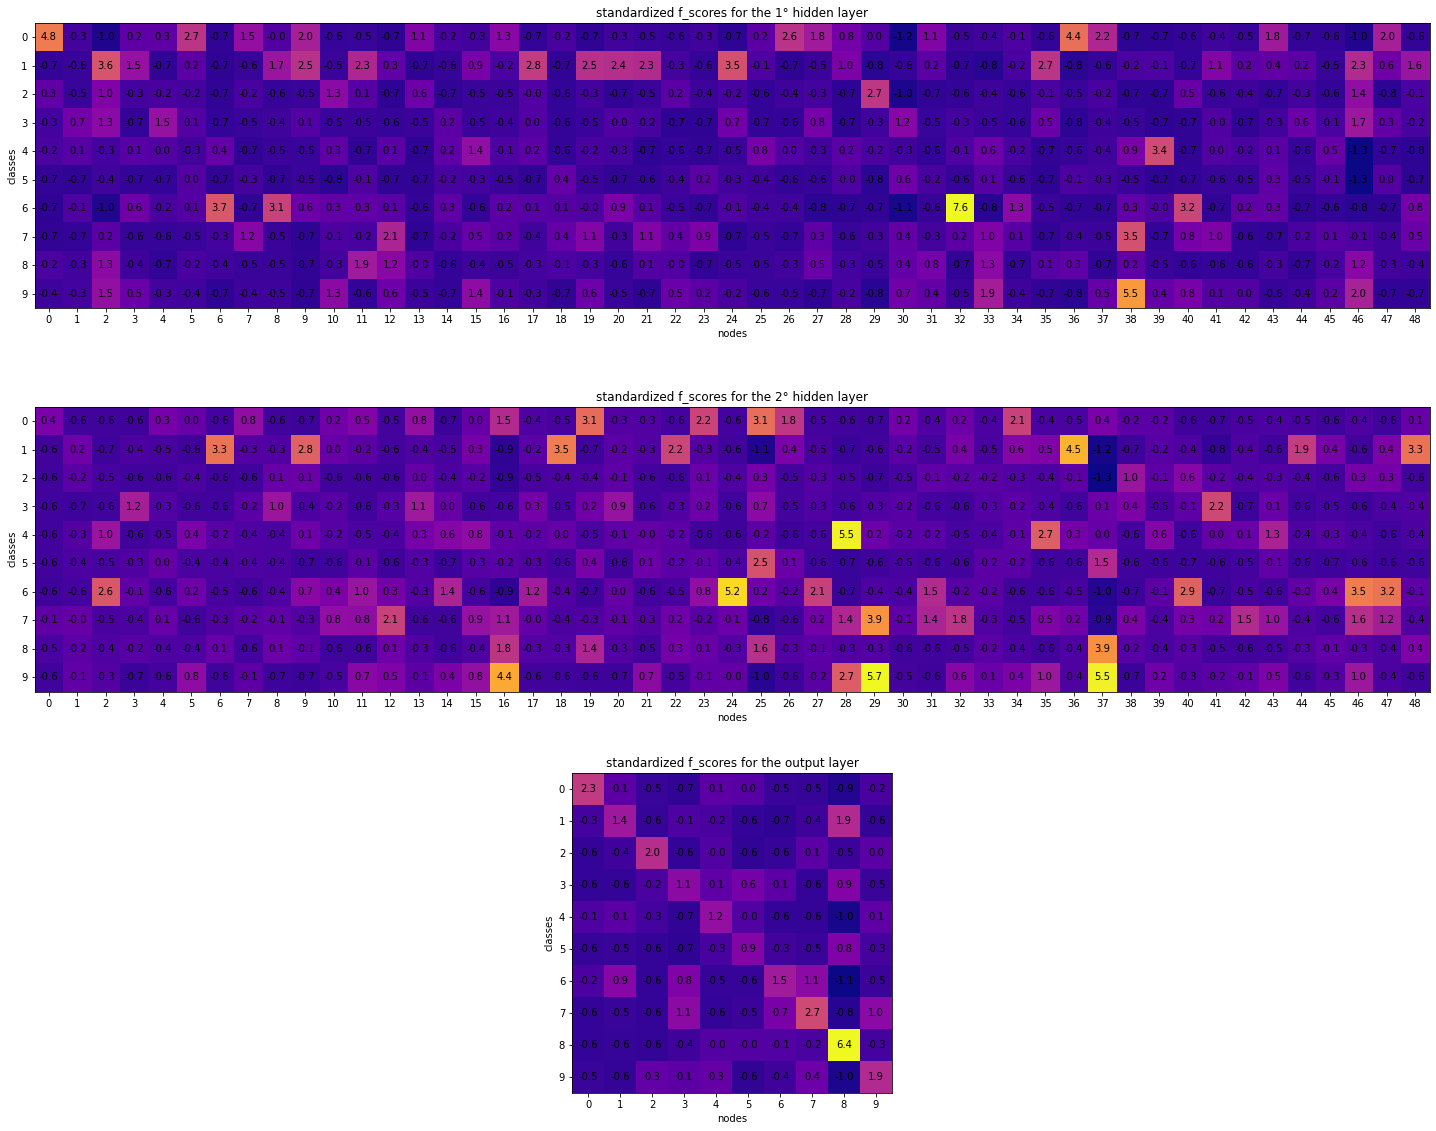

In [169]:
fig, axs = plt.subplots(figsize=(25, 20), nrows=3, ncols=1)

for L in range(len(shapes)):
    axs[L].imshow(F_scoresB[L], cmap='plasma')
    axs[L].set_xlabel('nodes')
    axs[L].set_xticks(range(shapes[L]))

    axs[L].set_ylabel('classes')
    axs[L].set_yticks(range(10))
    axs[L].set_title(f'standardized f_scores for the {layers_name[L]} layer')

    for (i, j), f in np.ndenumerate(F_scoresB[L]):
        axs[L].text(j, i, f'{f:.1f}', ha='center', va='center')


plt.show()

##### softmax

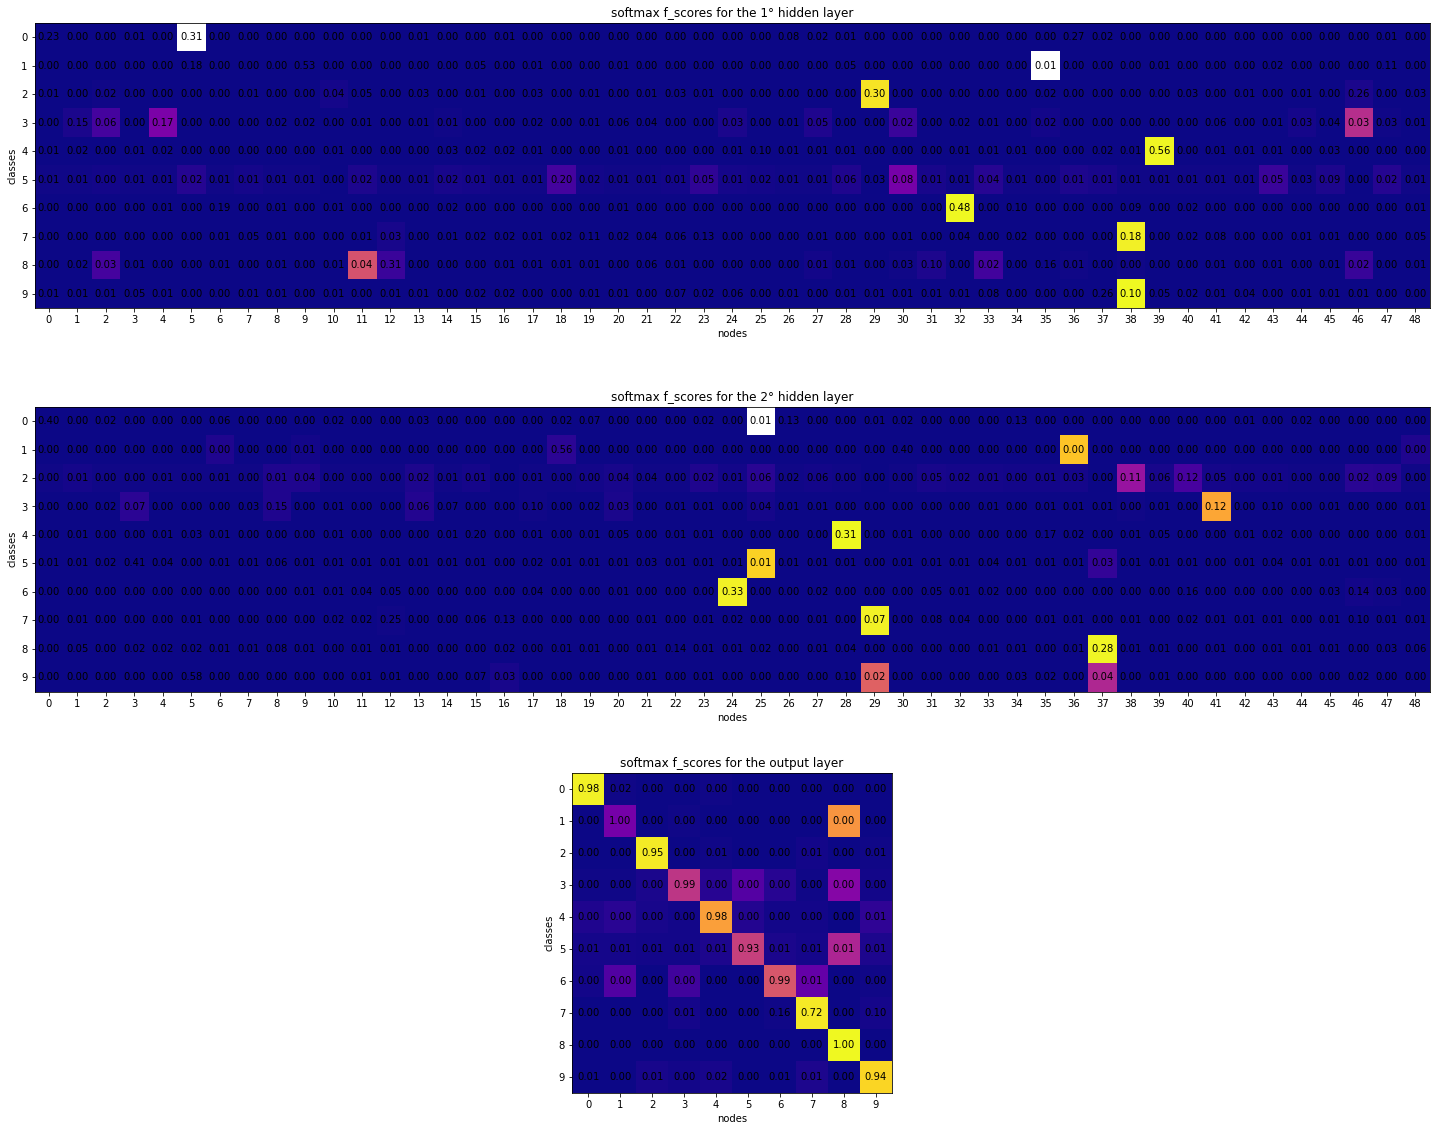

In [170]:
fig, axs = plt.subplots(figsize=(25, 20), nrows=3, ncols=1)

for L in range(3):
    axs[L].imshow(F_scores_sfB[L], cmap='plasma')
    axs[L].set_xlabel('nodes')
    axs[L].set_xticks(range(shapes[L]))

    axs[L].set_ylabel('classes')
    axs[L].set_yticks(range(10))
    axs[L].set_title(f'softmax f_scores for the {layers_name[L]} layer')

    for (i, j), f in np.ndenumerate(F_scores_sf[L]):
        axs[L].text(j, i, f'{f:.2f}', ha='center', va='center')


plt.show()

output layer
 ---------------------------------------------------------------------------------------------------- 



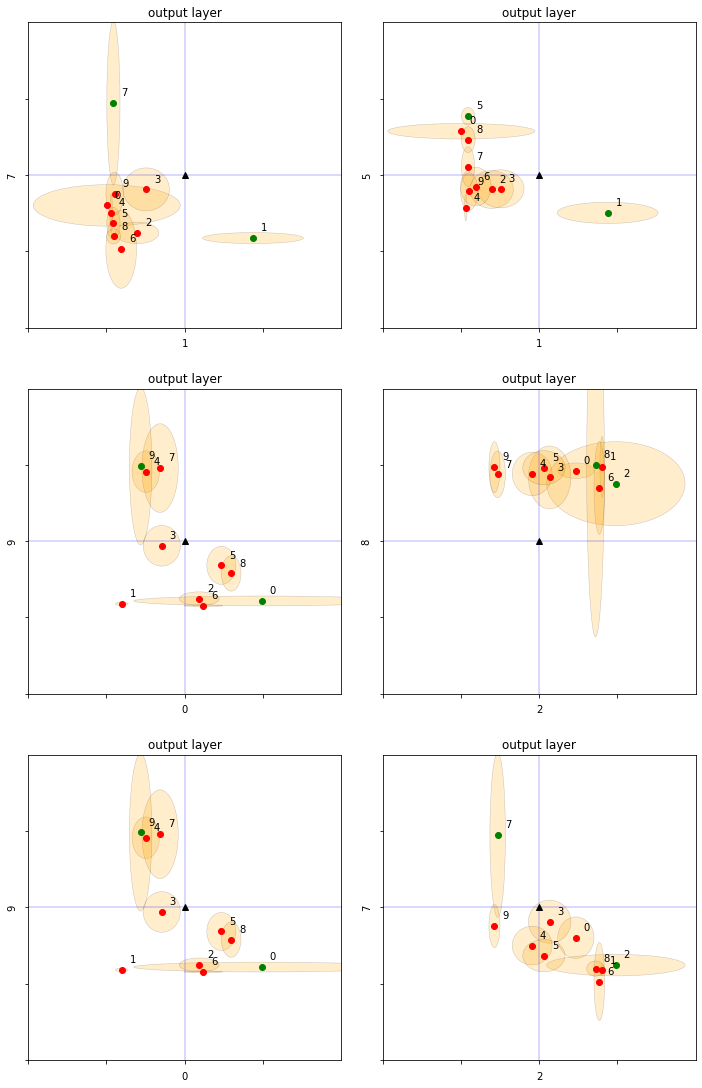

In [57]:
L = 2

nr = 3
nc = 2

lim = 2

#########################################################################################################################

print(f'{layers_name[L]} layer\n', '-'*100, '\n')
fig, axs = plt.subplots(figsize=(10, 15), nrows=nr, ncols = nc)
fig.tight_layout(h_pad=4)

cmap = cm.get_cmap(name='rainbow')

for row in range(nr):
    for col in range(nc):

        mu_v = np.zeros((10, 2))
        f_v = np.zeros((10, 2))

        u1, u2 = np.random.randint(0, shapes[L]//2), np.random.randint(shapes[L]//2, shapes[L])
            
        axs[row][col].axhline(0, color='blue', alpha=0.2)
        axs[row][col].axvline(0, color='blue', alpha=0.2)

        # for each class k
        for k in range(10):
            # point location: mean
            mu_v[k, 0] = C_all_muB[L][u1, k]  # dim 1
            mu_v[k, 1] = C_all_muB[L][u2, k]  # dim 2

            # ellipse dims: axis-stdv
            f_v[k, 0] = F_scoresB[L][k, u1]  # dim 1
            f_v[k, 1] = F_scoresB[L][k, u2]  # dim 2

            if k == u1 or k == u2:
                axs[row][col].plot(mu_v[k, 0], mu_v[k, 1], 'og')
            else:
                axs[row][col].plot(mu_v[k, 0], mu_v[k, 1], 'or')

        for k, x, y in zip(range(10), mu_v[:, 0], mu_v[:, 1]):
            axs[row][col].annotate(f'{k}', xy=(x+0.1, y+0.1), textcoords='data')
            ellipse = Ellipse((x, y), width=f_v[k, 0], height=f_v[k, 1], facecolor='orange', alpha=0.2, edgecolor='black',linestyle='-',linewidth='0.5')
            
            axs[row][col].add_patch(ellipse)
            axs[row][col].plot()
            axs[row][col].grid()

        axs[row][col].plot(0, 0, '^k')

        axs[row][col].set_title(f'{layers_name[L]} layer')
        axs[row][col].set_xlabel(f'{u1}')
        axs[row][col].set_ylabel(f'{u2}')

        axs[row][col].set_yticks(range(-lim, lim))
        axs[row][col].set_yticklabels(())
        axs[row][col].set_ylim((-lim, lim))

        axs[row][col].set_xticks(range(-lim, lim))
        axs[row][col].set_xticklabels(())
        axs[row][col].set_xlim((-lim, lim))

plt.show()

## Comparison ANN - BNN

2° hidden layer
 ---------------------------------------------------------------------------------------------------- 



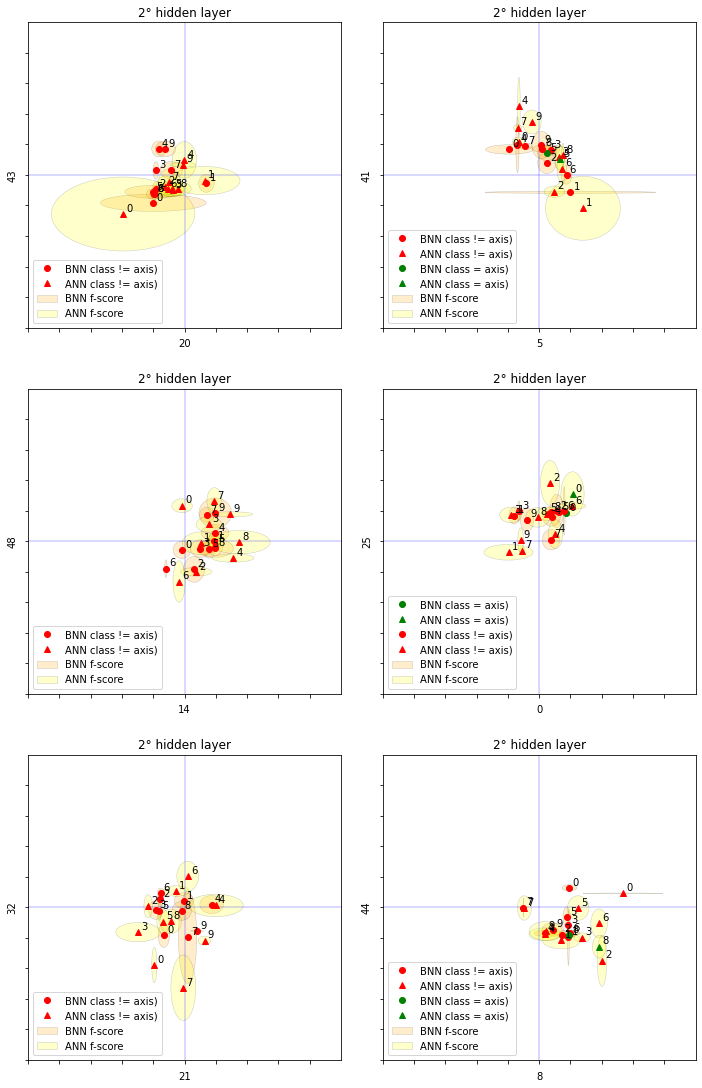

In [63]:
L = 1

nr = 3
nc = 2

lim = 5

#########################################################################################################################

print(f'{layers_name[L]} layer\n', '-'*100, '\n')
fig, axs = plt.subplots(figsize=(10, 15), nrows=nr, ncols = nc)
fig.tight_layout(h_pad=4)

cmap = cm.get_cmap(name='rainbow')

for row in range(nr):
    for col in range(nc):

        mu_v = np.zeros((10, 2))
        f_v = np.zeros((10, 2))
        
        mu_va = np.zeros((10, 2))
        f_va = np.zeros((10, 2))

        u1, u2 = np.random.randint(0, shapes[L]//2), np.random.randint(shapes[L]//2, shapes[L])
            
        axs[row][col].axhline(0, color='blue', alpha=0.2)
        axs[row][col].axvline(0, color='blue', alpha=0.2)

        go = True
        
        # for each class k
        for k in range(10):
            # point location: mean
            mu_v[k, 0] = C_all_muB[L][u1, k]  # dim 1
            mu_v[k, 1] = C_all_muB[L][u2, k]  # dim 2
            
            mu_va[k, 0] = C_all_mu[L][u1, k]  # dim 1
            mu_va[k, 1] = C_all_mu[L][u2, k]  # dim 2

            # ellipse dims: axis-stdv
            f_v[k, 0] = F_scoresB[L][k, u1]  # dim 1
            f_v[k, 1] = F_scoresB[L][k, u2]  # dim 2
            
            f_va[k, 0] = F_scores[L][k, u1]  # dim 1
            f_va[k, 1] = F_scores[L][k, u2]  # dim 2

            if k == u1 or k == u2:
                if k == u1:
                    axs[row][col].plot(mu_v[k, 0], mu_v[k, 1], 'og', label='BNN class = axis)')
                    axs[row][col].plot(mu_va[k, 0], mu_va[k, 1], '^g', label='ANN class = axis)')
                else:
                    axs[row][col].plot(mu_v[k, 0], mu_v[k, 1], 'og')
                    axs[row][col].plot(mu_va[k, 0], mu_va[k, 1], '^g')
            else:
                if go:
                    axs[row][col].plot(mu_v[k, 0], mu_v[k, 1], 'or', label='BNN class != axis)')
                    axs[row][col].plot(mu_va[k, 0], mu_va[k, 1], '^r', label='ANN class != axis)')
                    go = False
                else:
                    axs[row][col].plot(mu_v[k, 0], mu_v[k, 1], 'or')
                    axs[row][col].plot(mu_va[k, 0], mu_va[k, 1], '^r')

        for k, x, y in zip(range(10), mu_v[:, 0], mu_v[:, 1]):
            axs[row][col].annotate(f'{k}', xy=(x+0.1, y+0.1), textcoords='data')
            if k == 0:
                ellipse = Ellipse((x, y), width=f_v[k, 0], height=f_v[k, 1], facecolor='orange', alpha=0.2, edgecolor='black',linestyle='-',linewidth='0.5', label='BNN f-score')
            else:
                ellipse = Ellipse((x, y), width=f_v[k, 0], height=f_v[k, 1], facecolor='orange', alpha=0.2, edgecolor='black',linestyle='-',linewidth='0.5')
            
            axs[row][col].add_patch(ellipse)
            axs[row][col].plot()
            axs[row][col].grid()
            
        for k, x, y in zip(range(10), mu_va[:, 0], mu_va[:, 1]):
            axs[row][col].annotate(f'{k}', xy=(x+0.1, y+0.1), textcoords='data')
            if k == 0:
                ellipse = Ellipse((x, y), width=f_va[k, 0], height=f_va[k, 1], facecolor='yellow', alpha=0.2, edgecolor='black',linestyle='-',linewidth='0.5', label='ANN f-score')                
            else:
                ellipse = Ellipse((x, y), width=f_va[k, 0], height=f_va[k, 1], facecolor='yellow', alpha=0.2, edgecolor='black',linestyle='-',linewidth='0.5')
            
            axs[row][col].add_patch(ellipse)
            axs[row][col].plot()
            axs[row][col].grid()

        #axs[row][col].plot(0, 0, '^k')

        axs[row][col].set_title(f'{layers_name[L]} layer')
        axs[row][col].set_xlabel(f'{u1}')
        axs[row][col].set_ylabel(f'{u2}')

        axs[row][col].set_yticks(range(-lim, lim))
        axs[row][col].set_yticklabels(())
        axs[row][col].set_ylim((-lim, lim))

        axs[row][col].set_xticks(range(-lim, lim))
        axs[row][col].set_xticklabels(())
        axs[row][col].set_xlim((-lim, lim))
        
        axs[row][col].legend(loc=('lower left'))

plt.show()